In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis of Netflix data

## Initial data inspection

In [199]:
data = pd.read_csv('netflix_titles.csv')
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


We can see from this that there are missing values in columns director, cast, country, date_added, rating and duration.

## Handling missing values

In [201]:
data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

We have no way of figuring out what these values are supposed to be, so they will be replaced with "Unknown" so that we can show or hide these uncertain values later.

In [202]:
data = data.fillna("Unknown")

## Data cleaning

Columns cast and listed_in will be replaced with lists including the current values in an easier-to-use format.

In [203]:
data["cast"] = [y for x in [[z.split(", ")] for z in data["cast"]] for y in x]

In [204]:
data["listed_in"] = [y for x in [[z.split(", ")] for z in data["listed_in"]] for y in x]

Lets now add new columns for the date_added to access the information more easily.

In [205]:
data["year_added"] = [-1 if x=="Unknown" else x.lstrip(" ").split(" ")[2] for x in data["date_added"]]
months = np.array(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
data["month_added"] = [-1 if x=="Unknown" else np.argwhere(months == x.lstrip(" ").split(" ")[0])[0][0]+1 for x in data["date_added"]]
data["day_added"] = [-1 if x=="Unknown" else x.lstrip(" ").split(", ")[0].split(" ")[1] for x in data["date_added"]]

We can now drop the redundant date_added column

In [206]:
data = data.drop("date_added", axis="columns")

In [207]:
data.head()

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,year_added,month_added,day_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,[Unknown],United States,2020,PG-13,90 min,[Documentaries],"As her father nears the end of his life, filmm...",2021,9,25
1,s2,TV Show,Blood & Water,Unknown,"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",South Africa,2021,TV-MA,2 Seasons,"[International TV Shows, TV Dramas, TV Mysteries]","After crossing paths at a party, a Cape Town t...",2021,9,24
2,s3,TV Show,Ganglands,Julien Leclercq,"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",Unknown,2021,TV-MA,1 Season,"[Crime TV Shows, International TV Shows, TV Ac...",To protect his family from a powerful drug lor...,2021,9,24
3,s4,TV Show,Jailbirds New Orleans,Unknown,[Unknown],Unknown,2021,TV-MA,1 Season,"[Docuseries, Reality TV]","Feuds, flirtations and toilet talk go down amo...",2021,9,24
4,s5,TV Show,Kota Factory,Unknown,"[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",India,2021,TV-MA,2 Seasons,"[International TV Shows, Romantic TV Shows, TV...",In a city of coaching centers known to train I...,2021,9,24


## Univariate analysis

### Numerical variables

First we can visualise the amount of content added.

<Axes: xlabel='year_added', ylabel='count'>

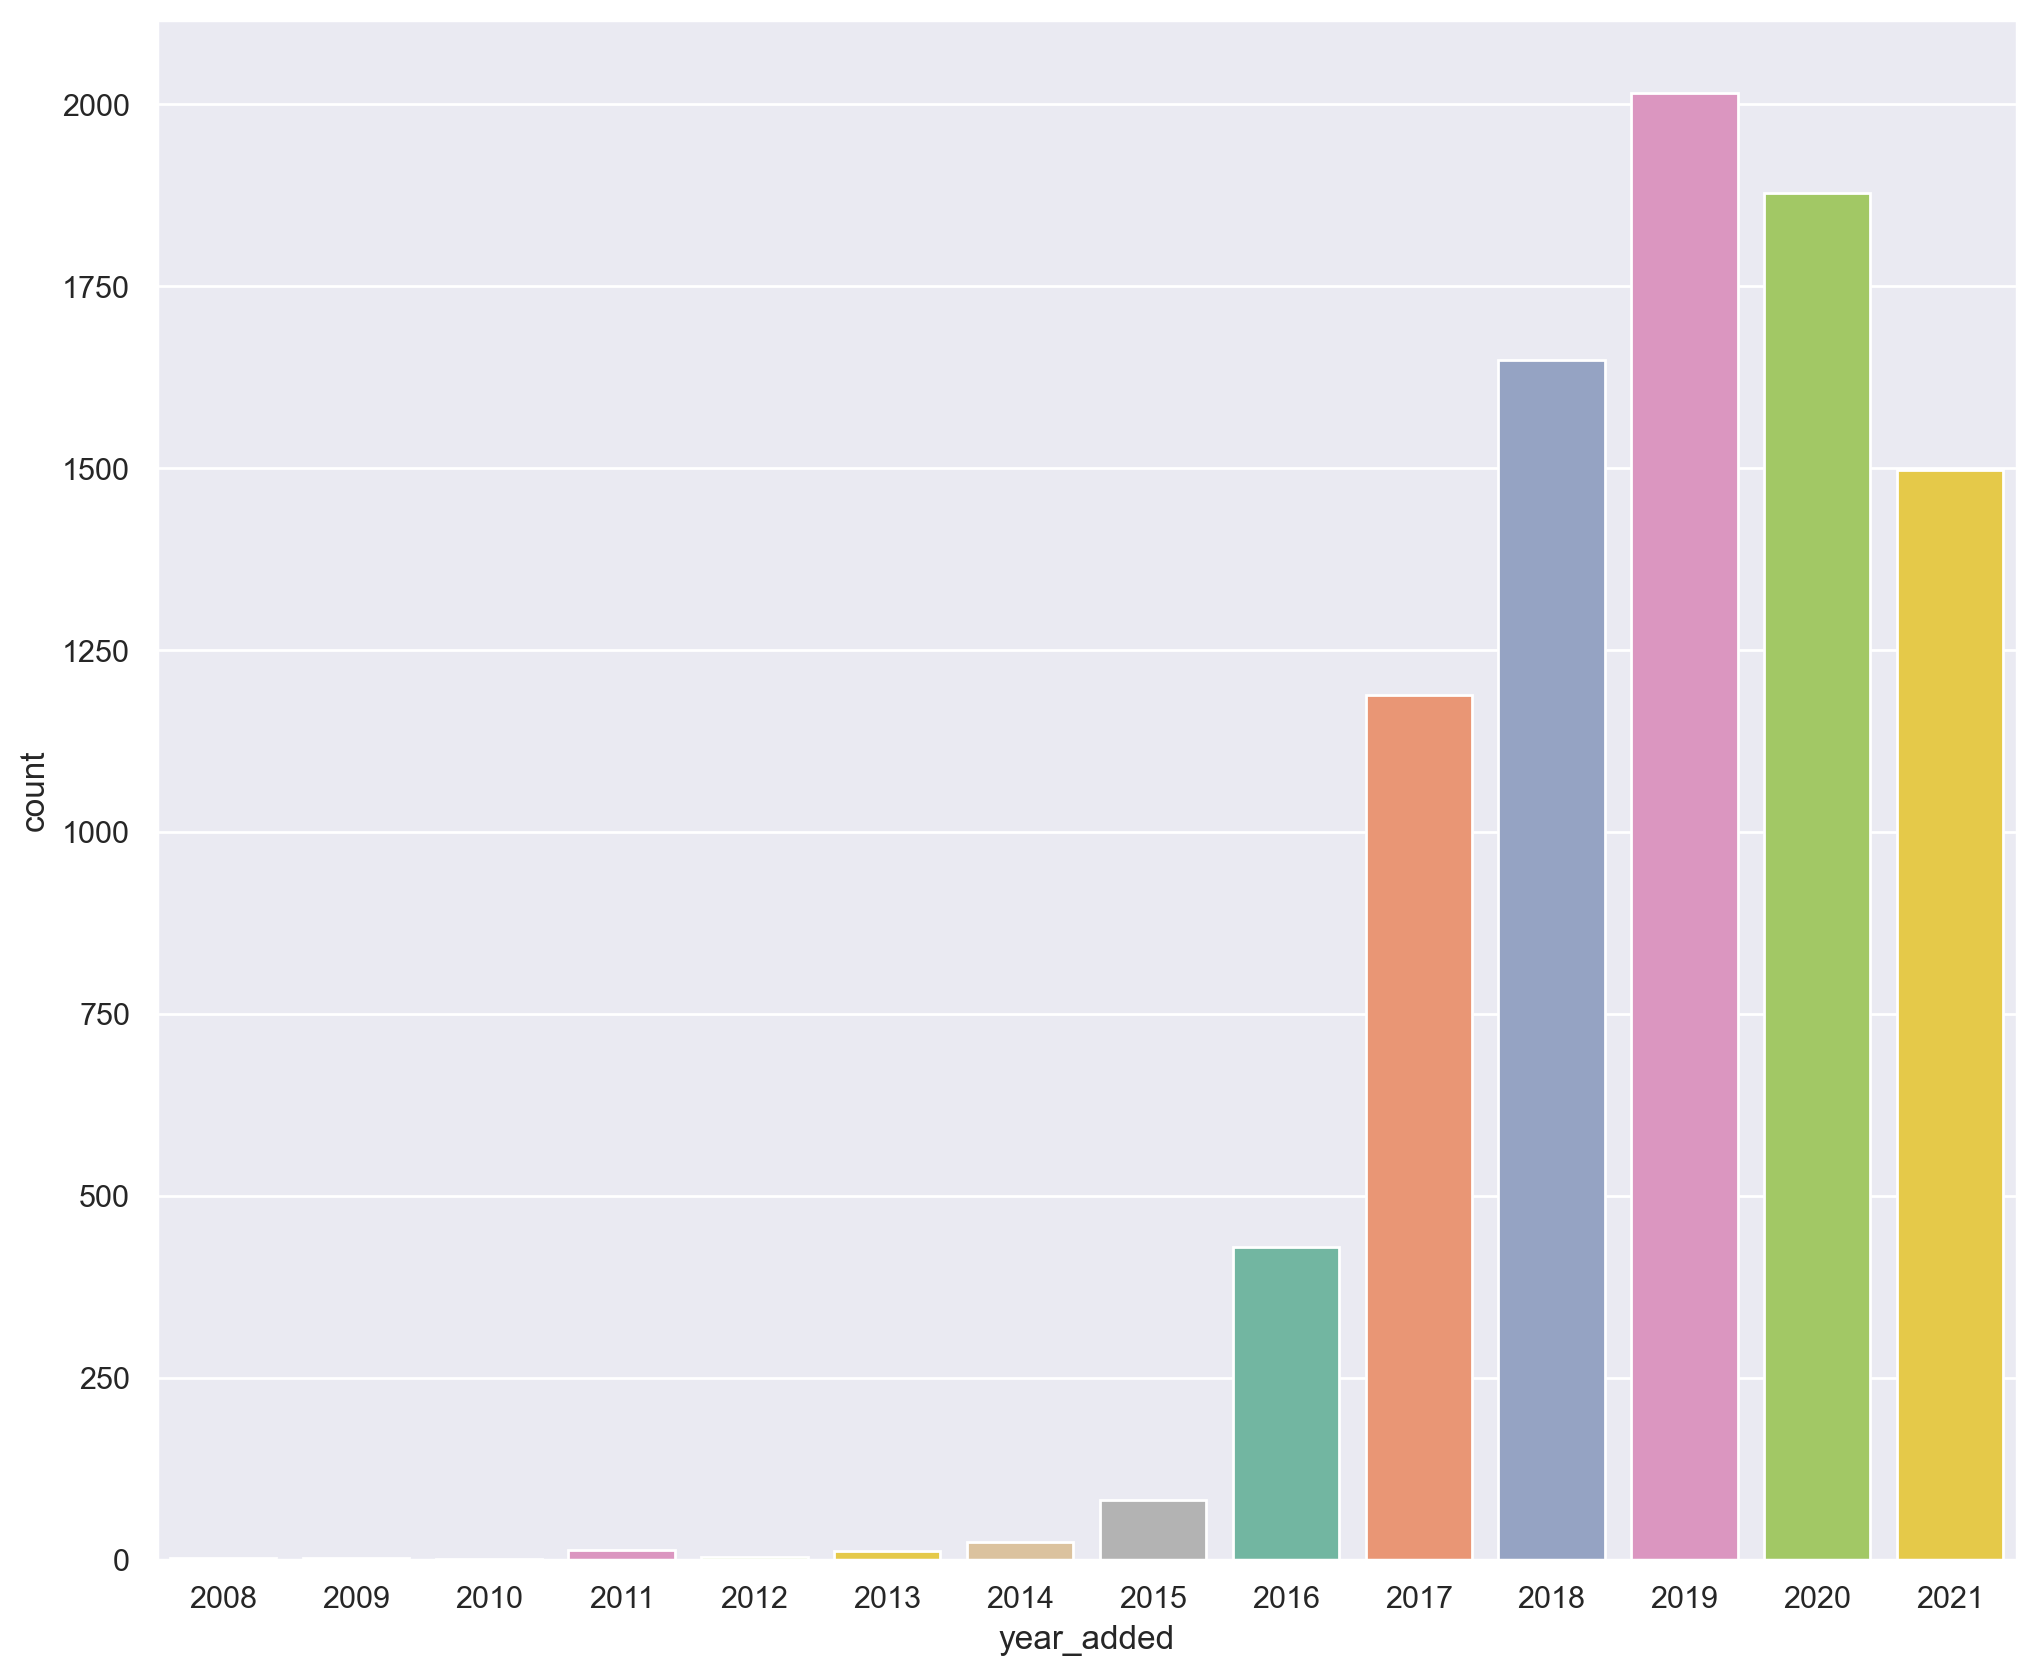

In [208]:
plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="year_added", data=data[data["year_added"]!=-1], palette="Set2", order=data[data["year_added"]!=-1]["year_added"].value_counts().index[0:].sort_values())

We can see that content was originally added very slowly until year 2014-2015 when this amount experienced an exponential growth that started gradually slowing down after 2019.

<Axes: xlabel='release_year', ylabel='count'>

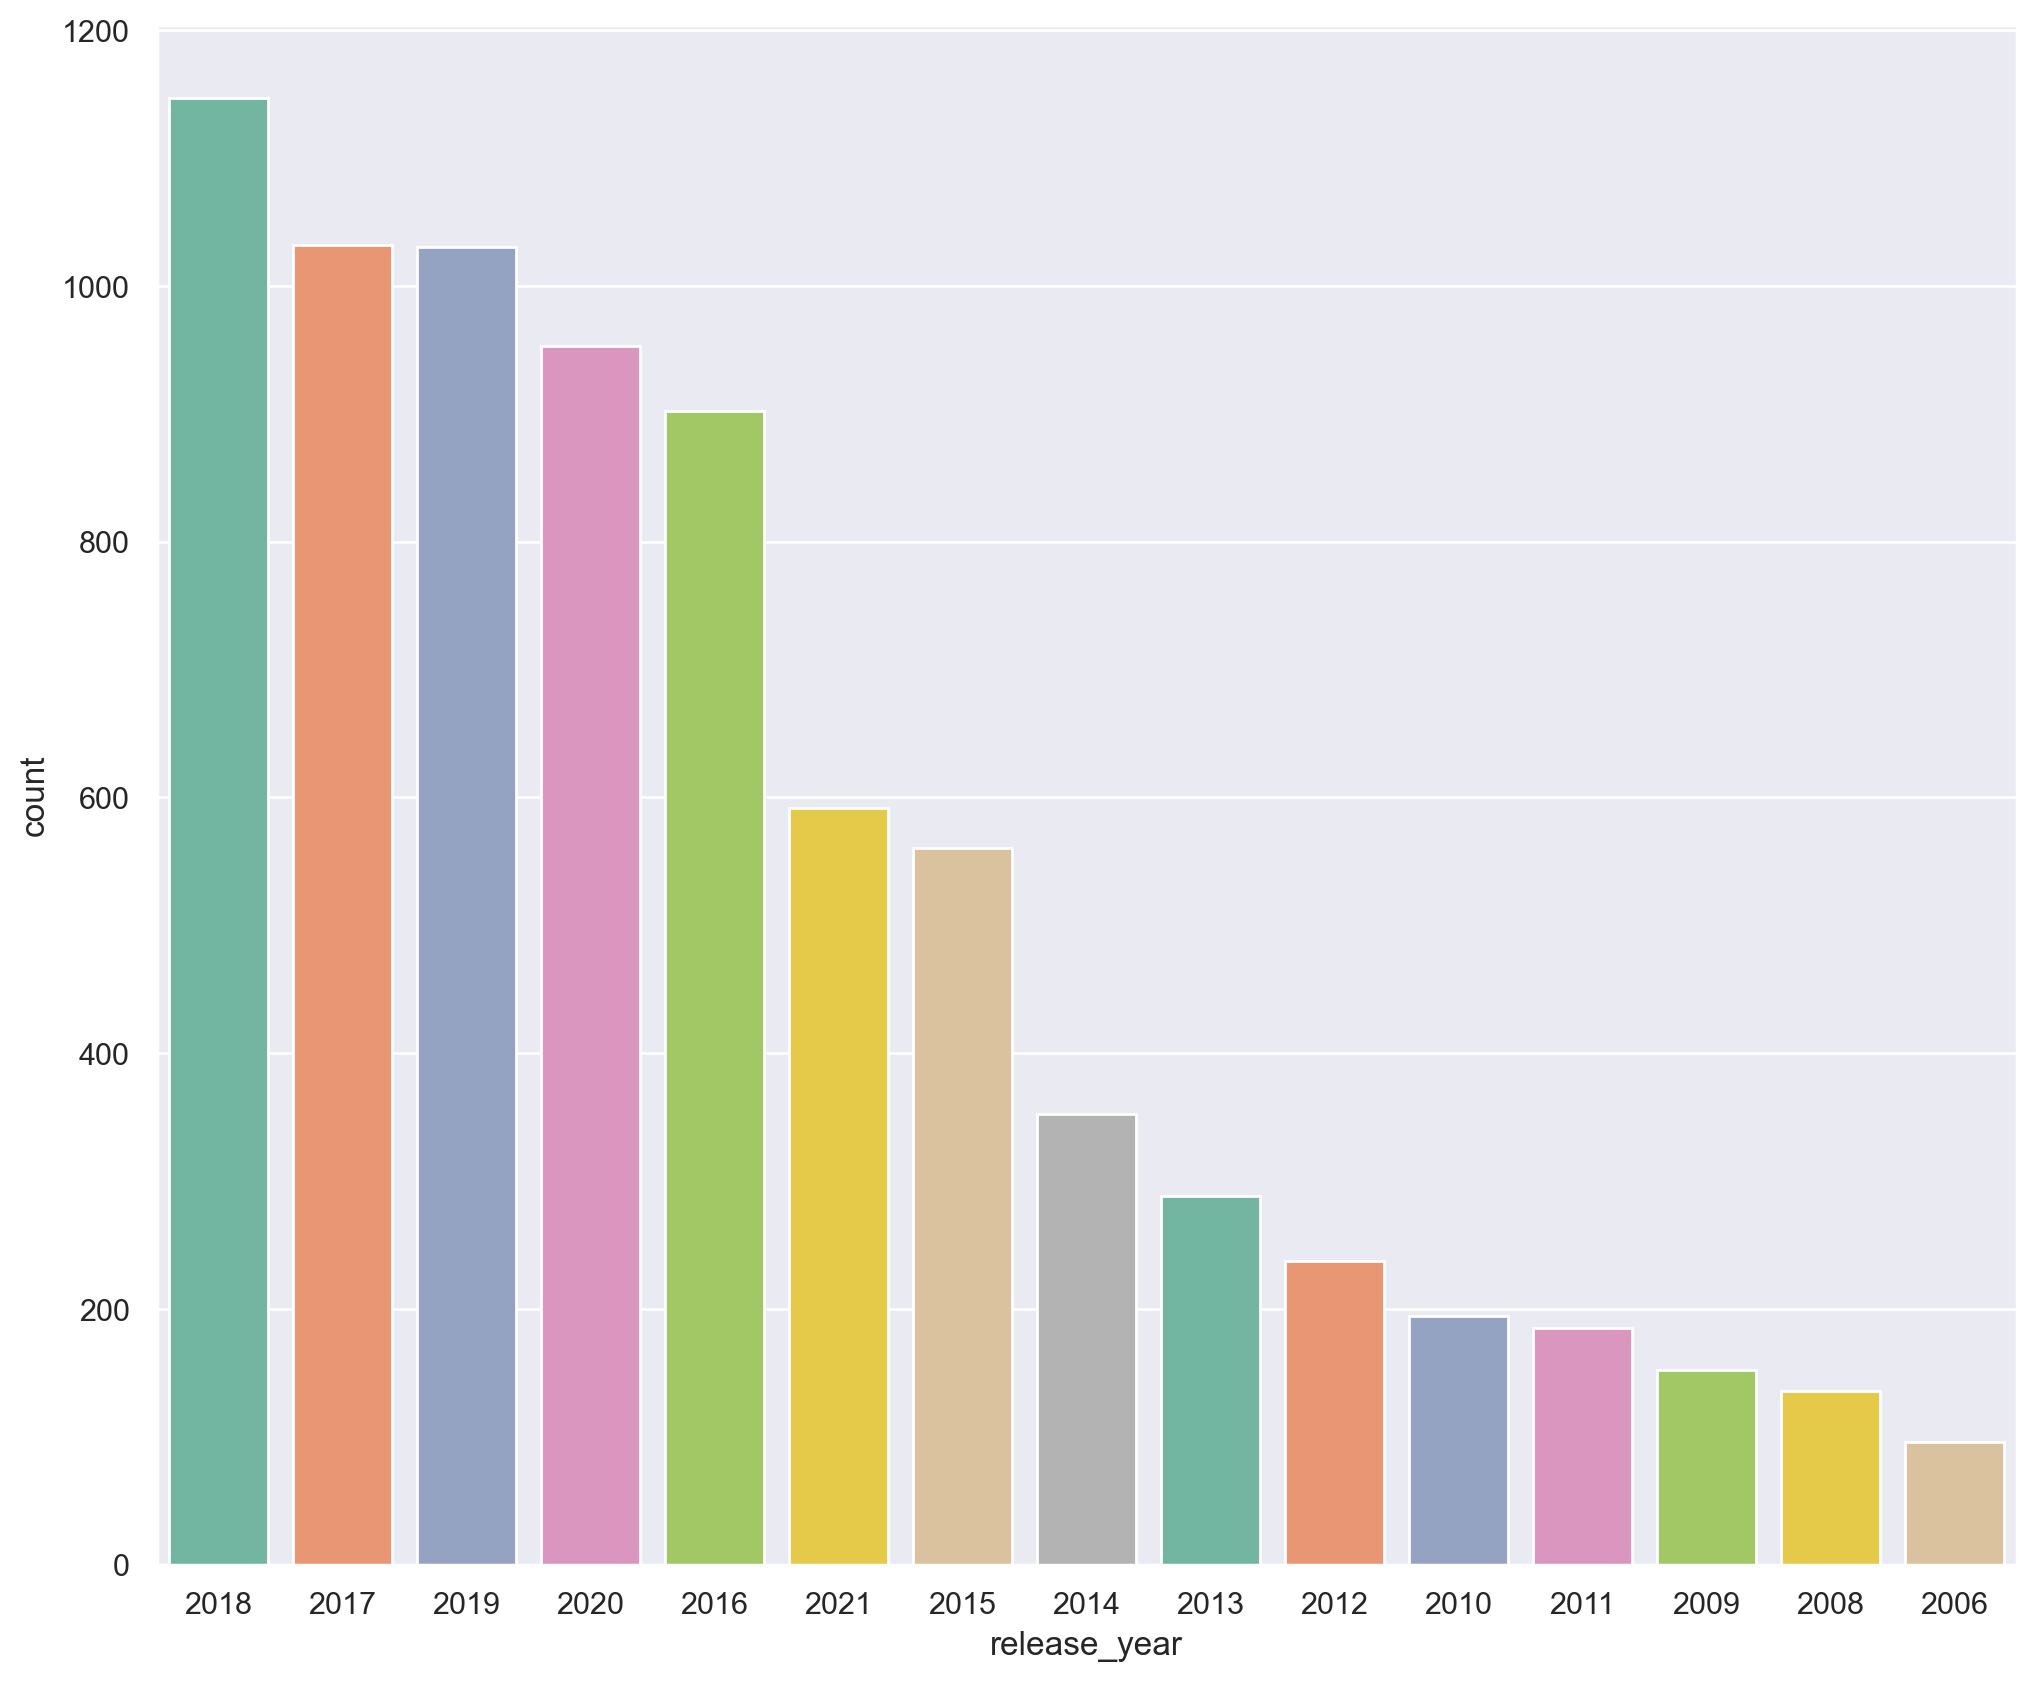

In [209]:
plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="release_year", data=data, palette="Set2", order=data["release_year"].value_counts().index[0:15])

We can see that most of the content has been released within the past decade but there is also a good sizable amount of older shows and movies.

<Figure size 2400x2000 with 0 Axes>

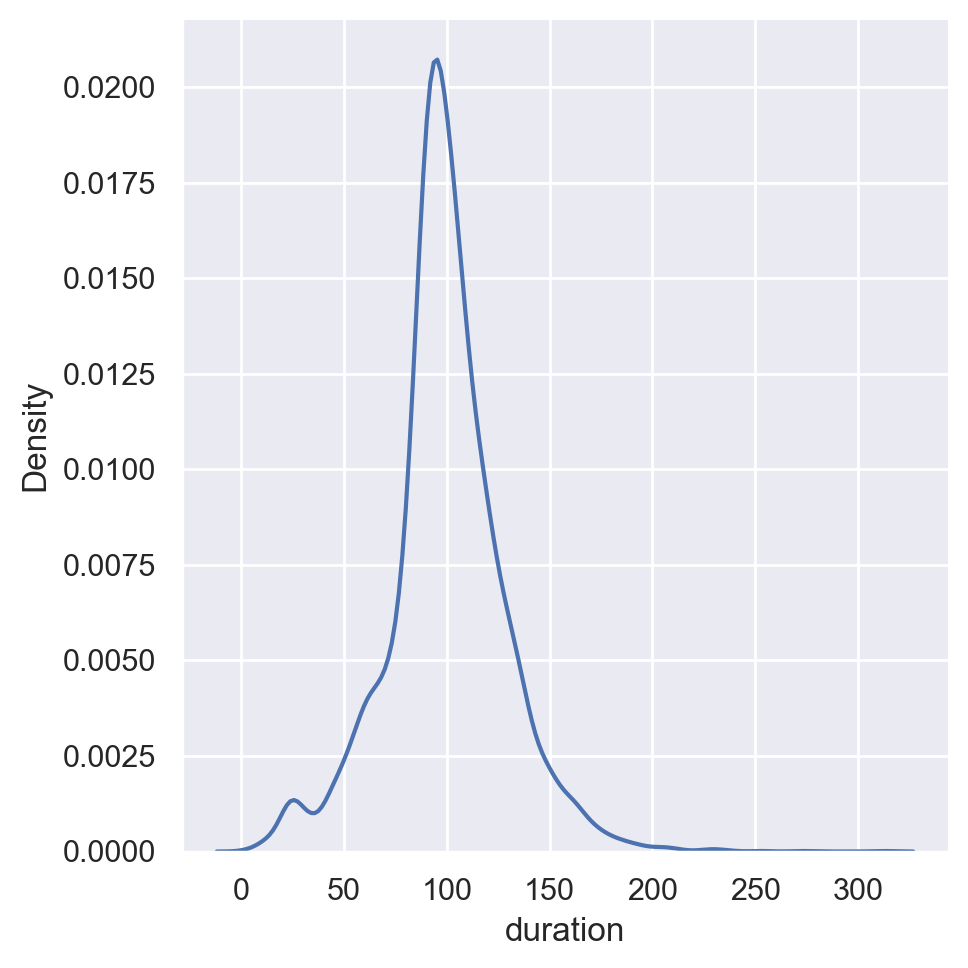

In [210]:
movies =  data[data["type"]=="Movie"]
movies["duration"] = [int(d.split(" ")[0]) if d!="Unknown" else -1 for d in movies["duration"]]

plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.displot(data=movies[movies["duration"]!=-1], x="duration", kind="kde")

We can see that most movies are 80-120 minutes long but that there are also short ones with a small spike around 30 minutes.

<Axes: xlabel='duration', ylabel='count'>

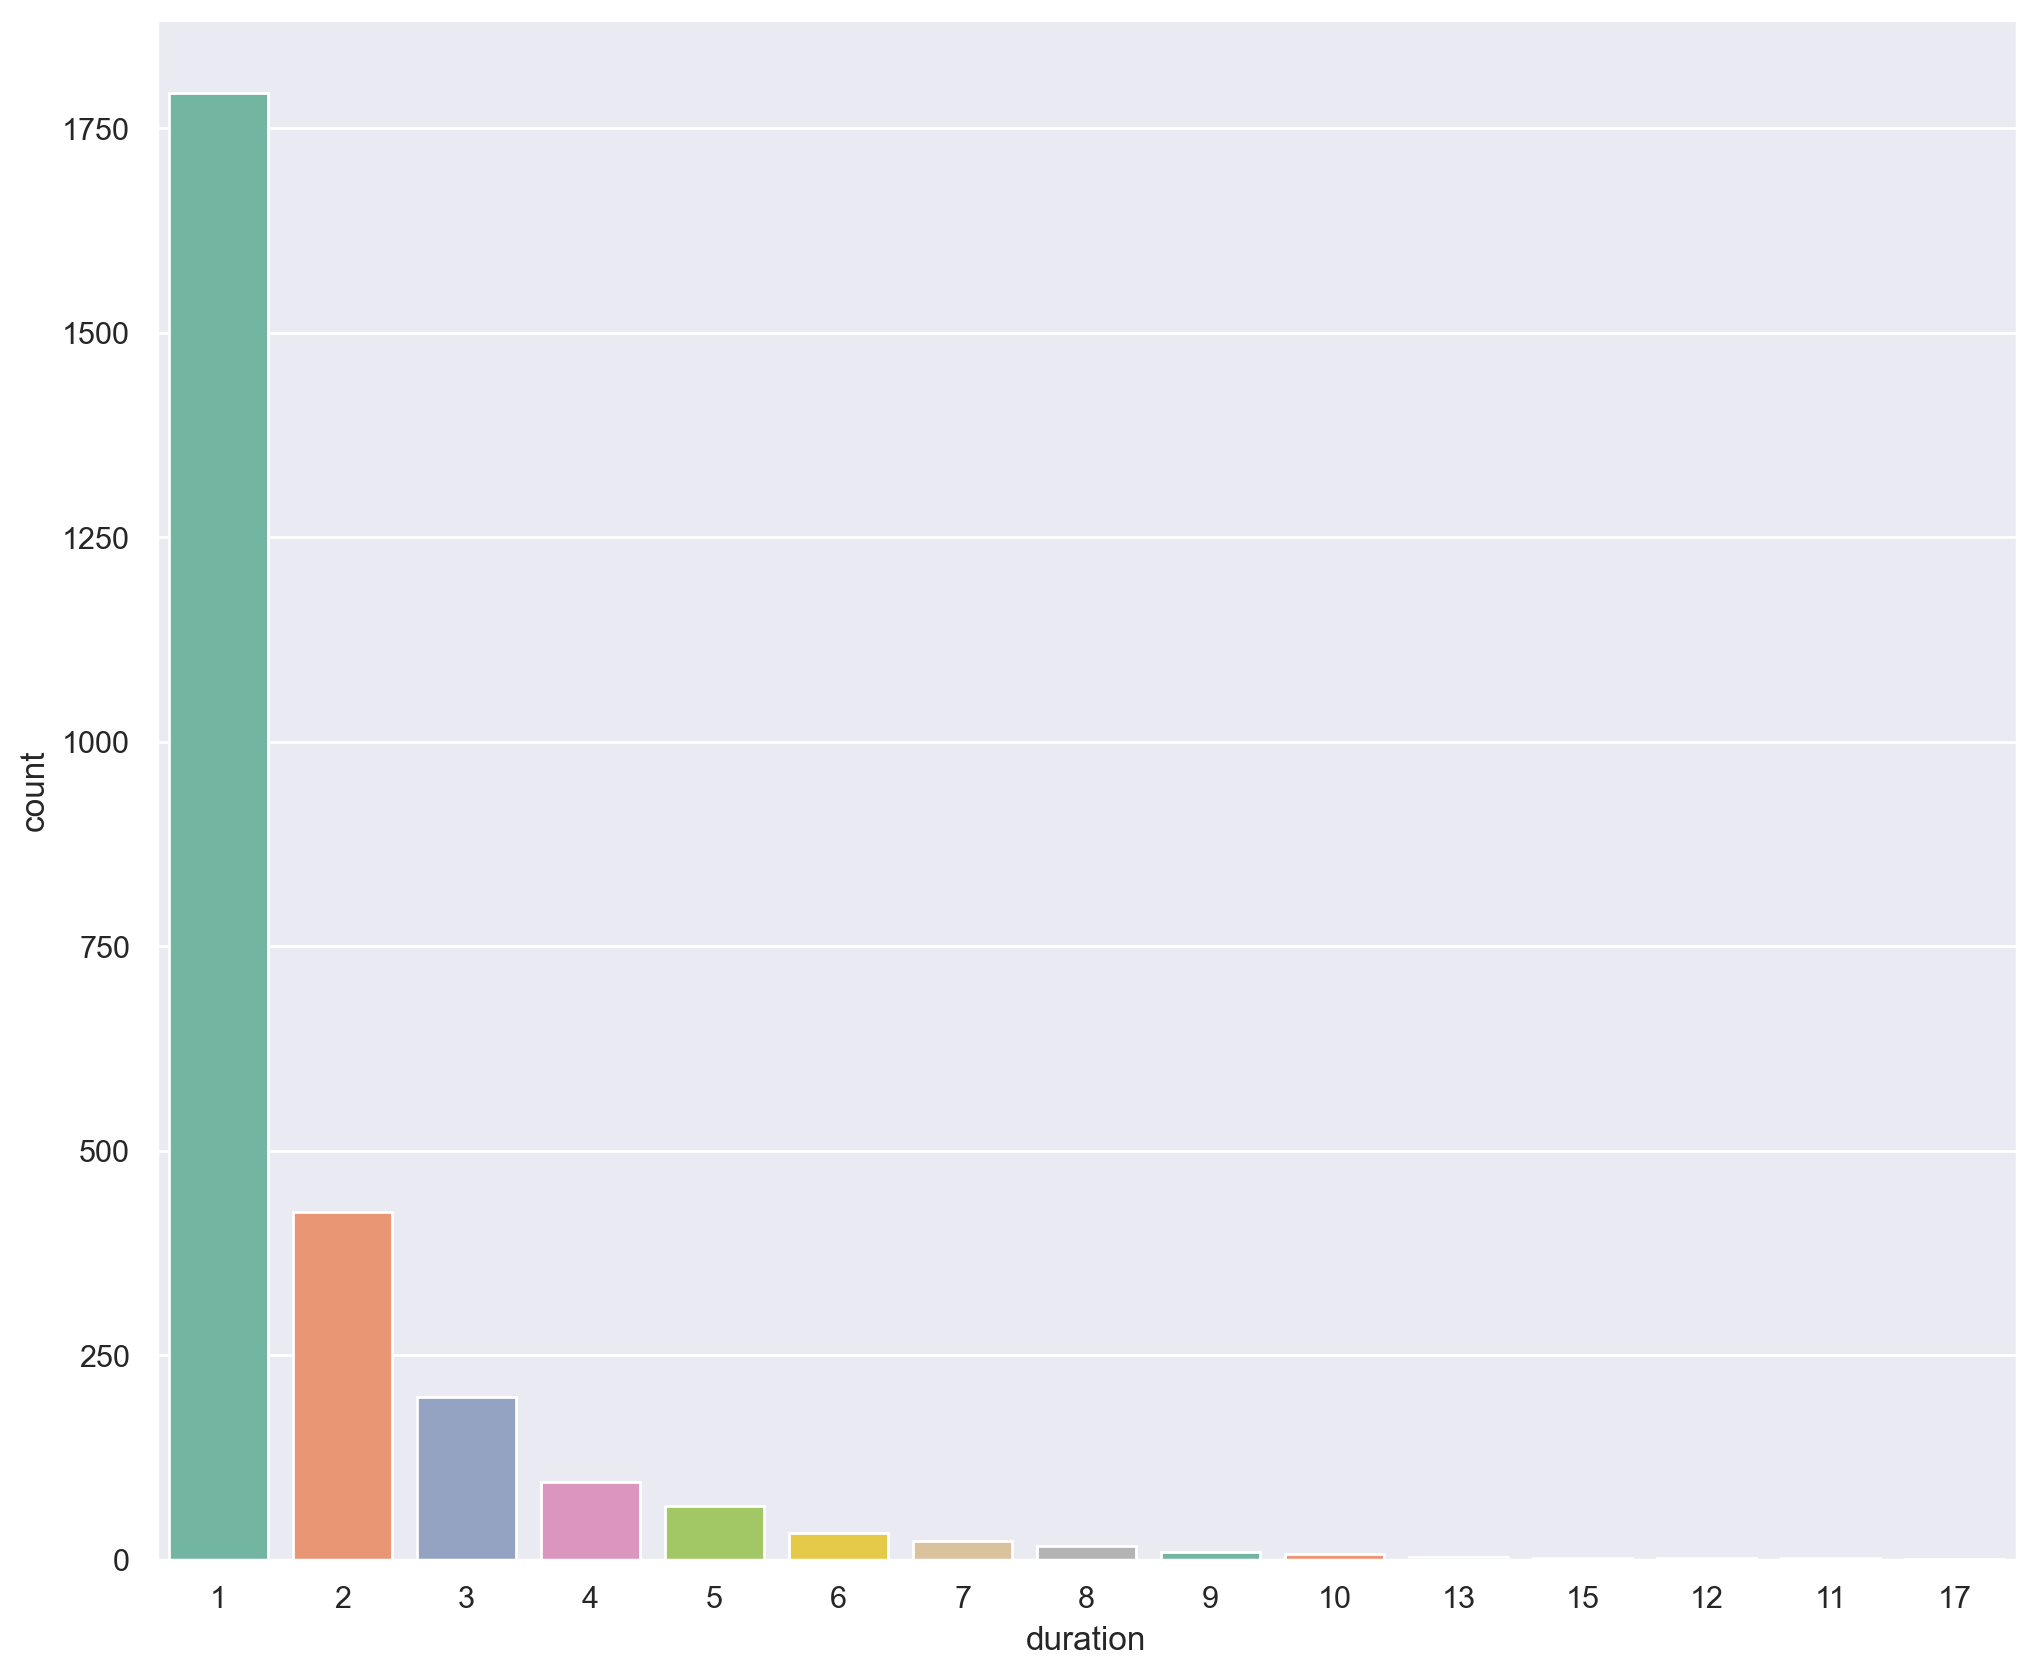

In [211]:
shows =  data[data["type"]=="TV Show"]
shows["duration"] = [int(d.lstrip().split(" ")[0]) if d!="Unknown" else -1 for d in shows["duration"]]

plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(data=shows[shows["duration"]!=-1], x="duration", palette="Set2", order=shows["duration"].value_counts().index[0:])

### Categorical variables

<Axes: xlabel='type', ylabel='count'>

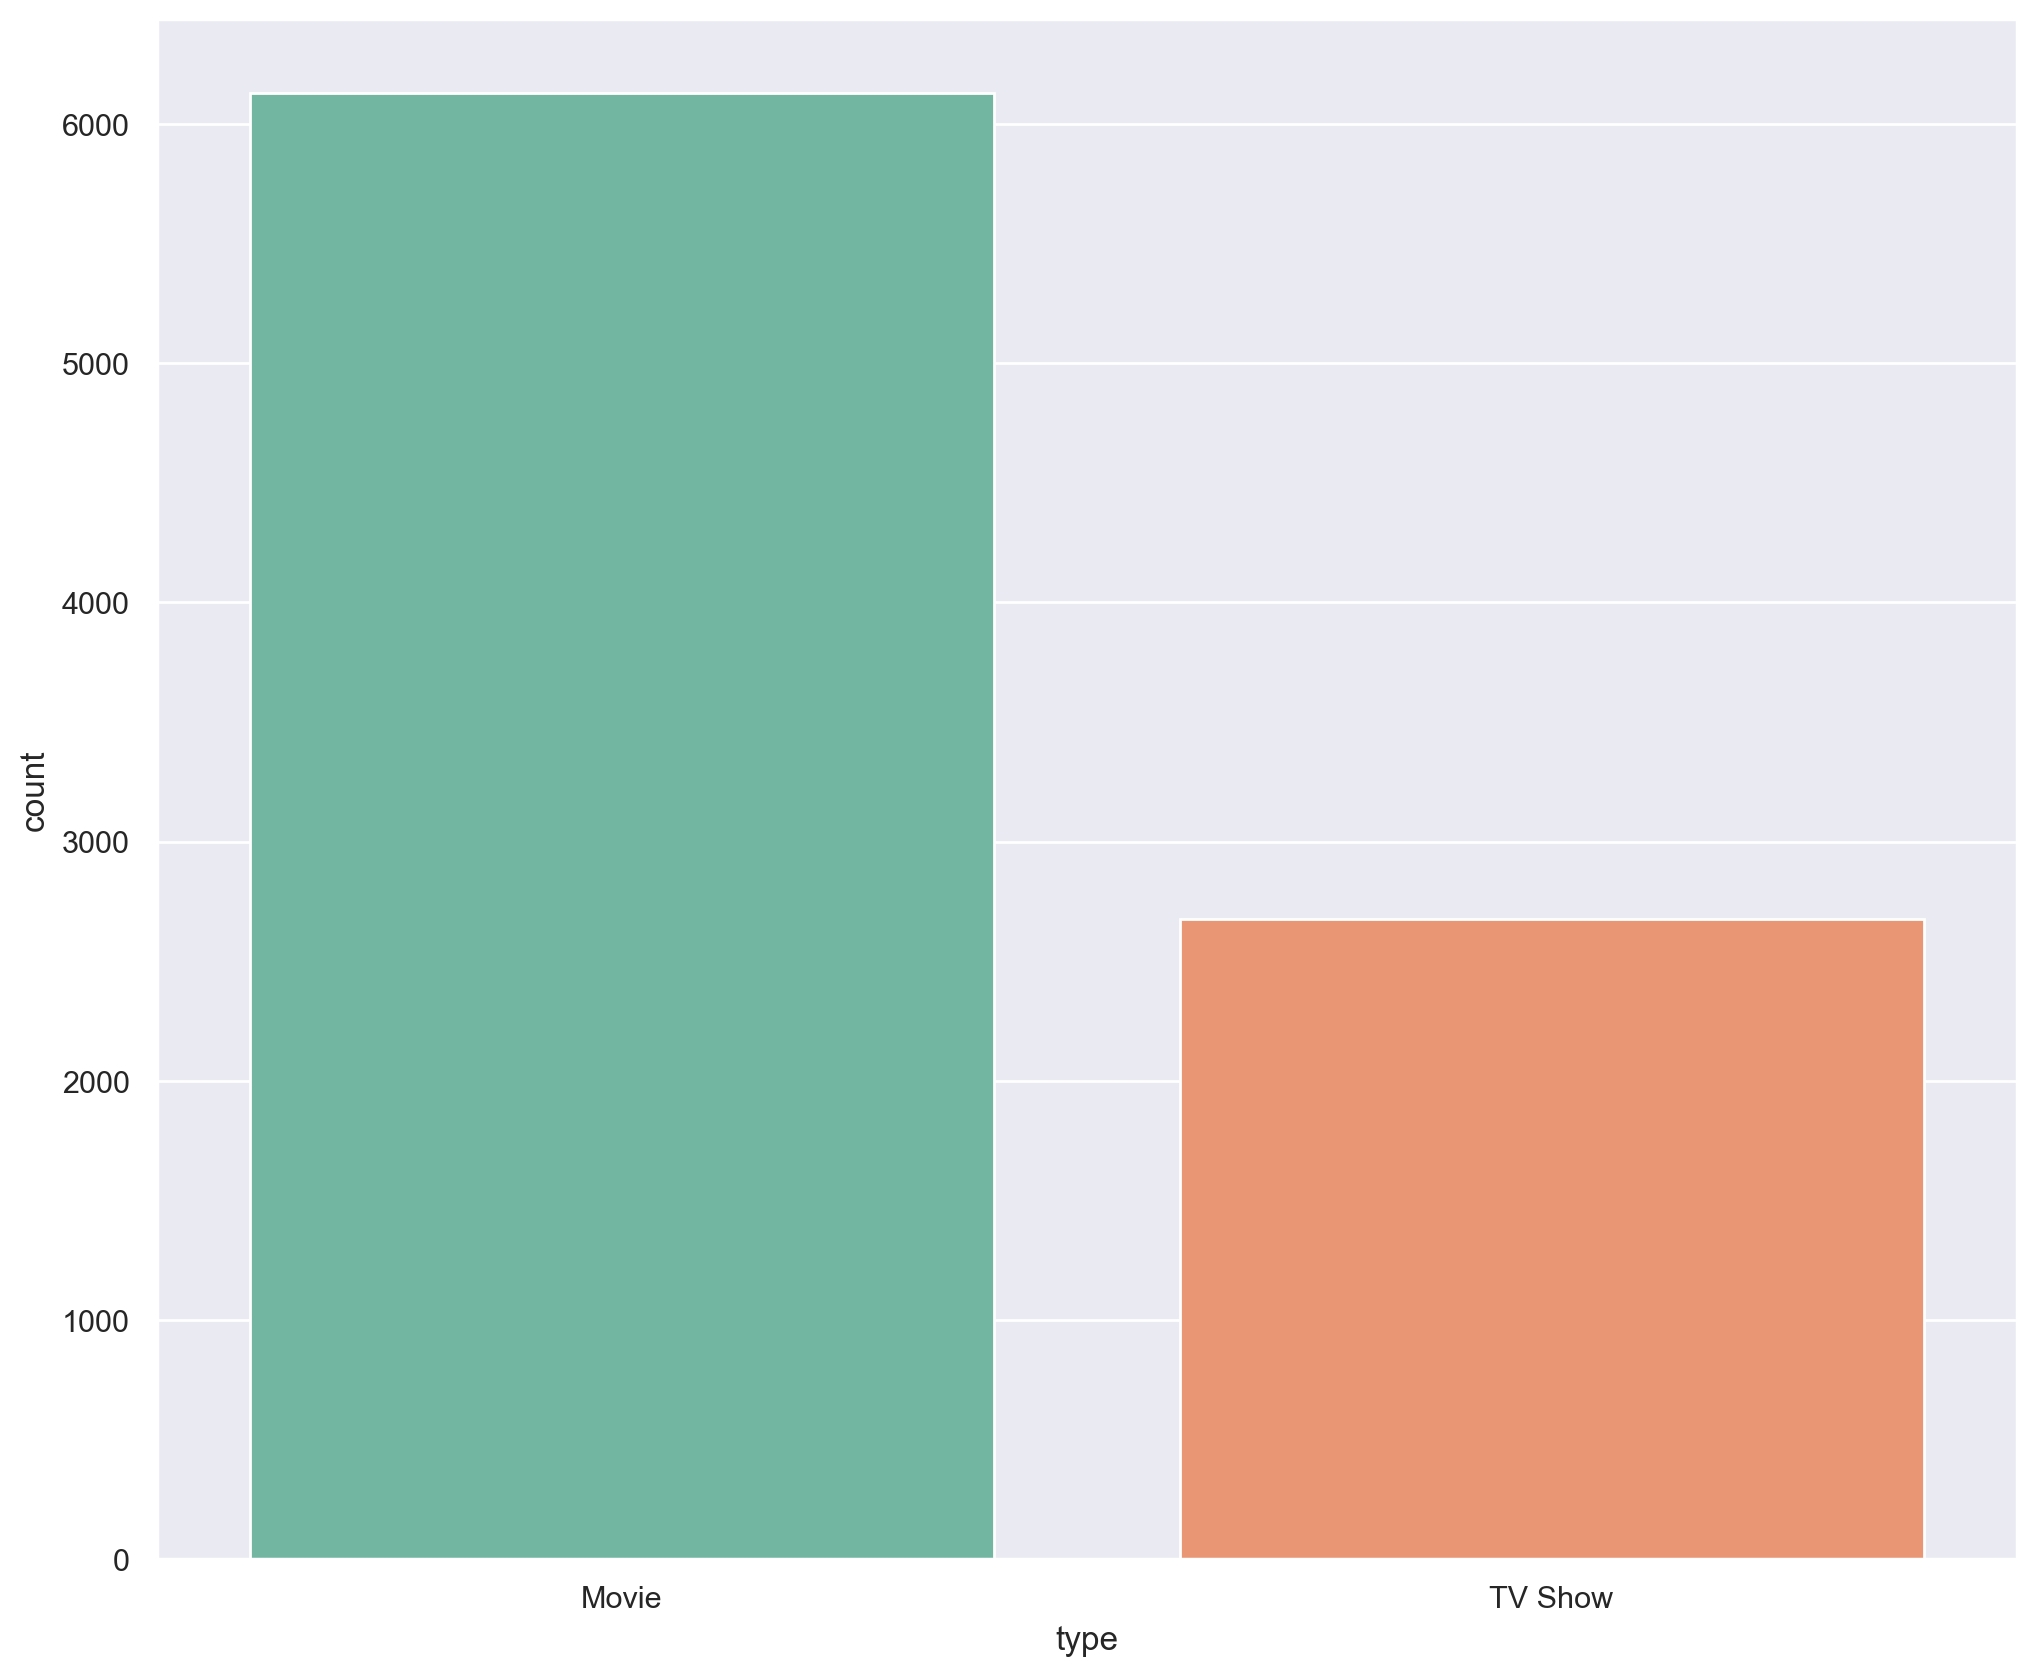

In [212]:
plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="type", data=data, palette="Set2", order=data["type"].value_counts().index[0:2])

There are a little over two times more movies than TV Shows on Netflix based on the data.

<Axes: xlabel='rating', ylabel='count'>

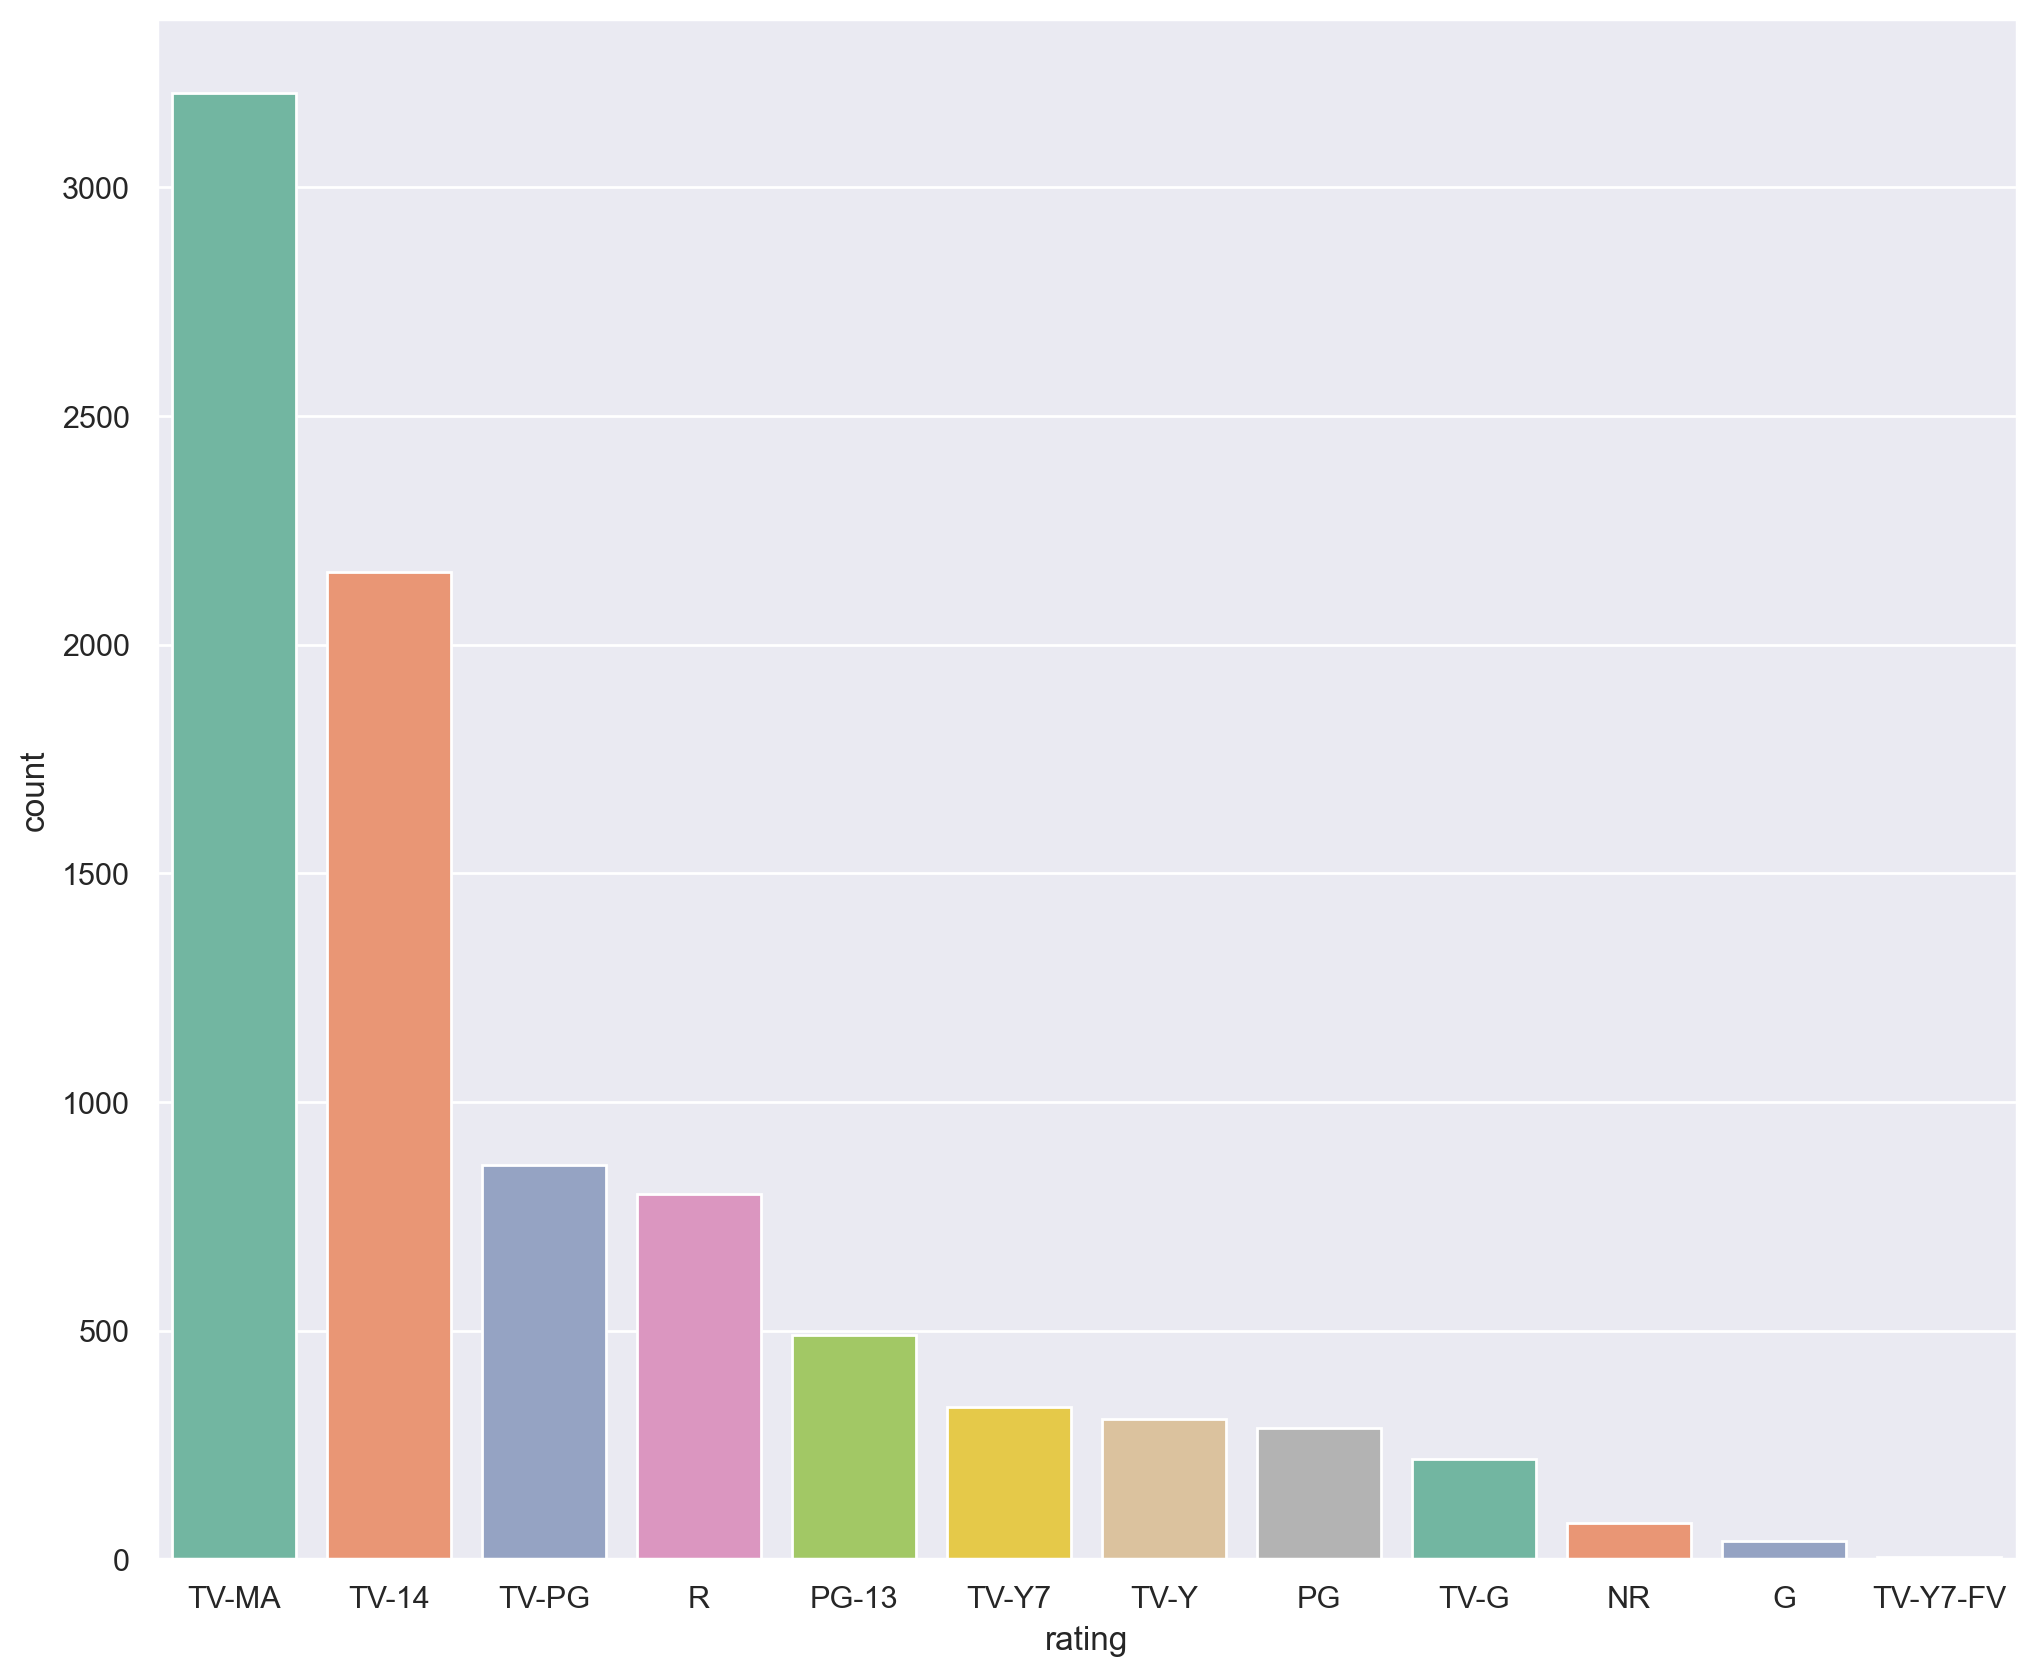

In [213]:
plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="rating", data=data, palette="Set2", order=data["rating"].value_counts().index[0:12])

Most of the content are either under rating TV-MA for mature audiences or TV-14 for ages 14 and up. From this we can see that the target audience is youths and adults.

<Axes: xlabel='Category', ylabel='count'>

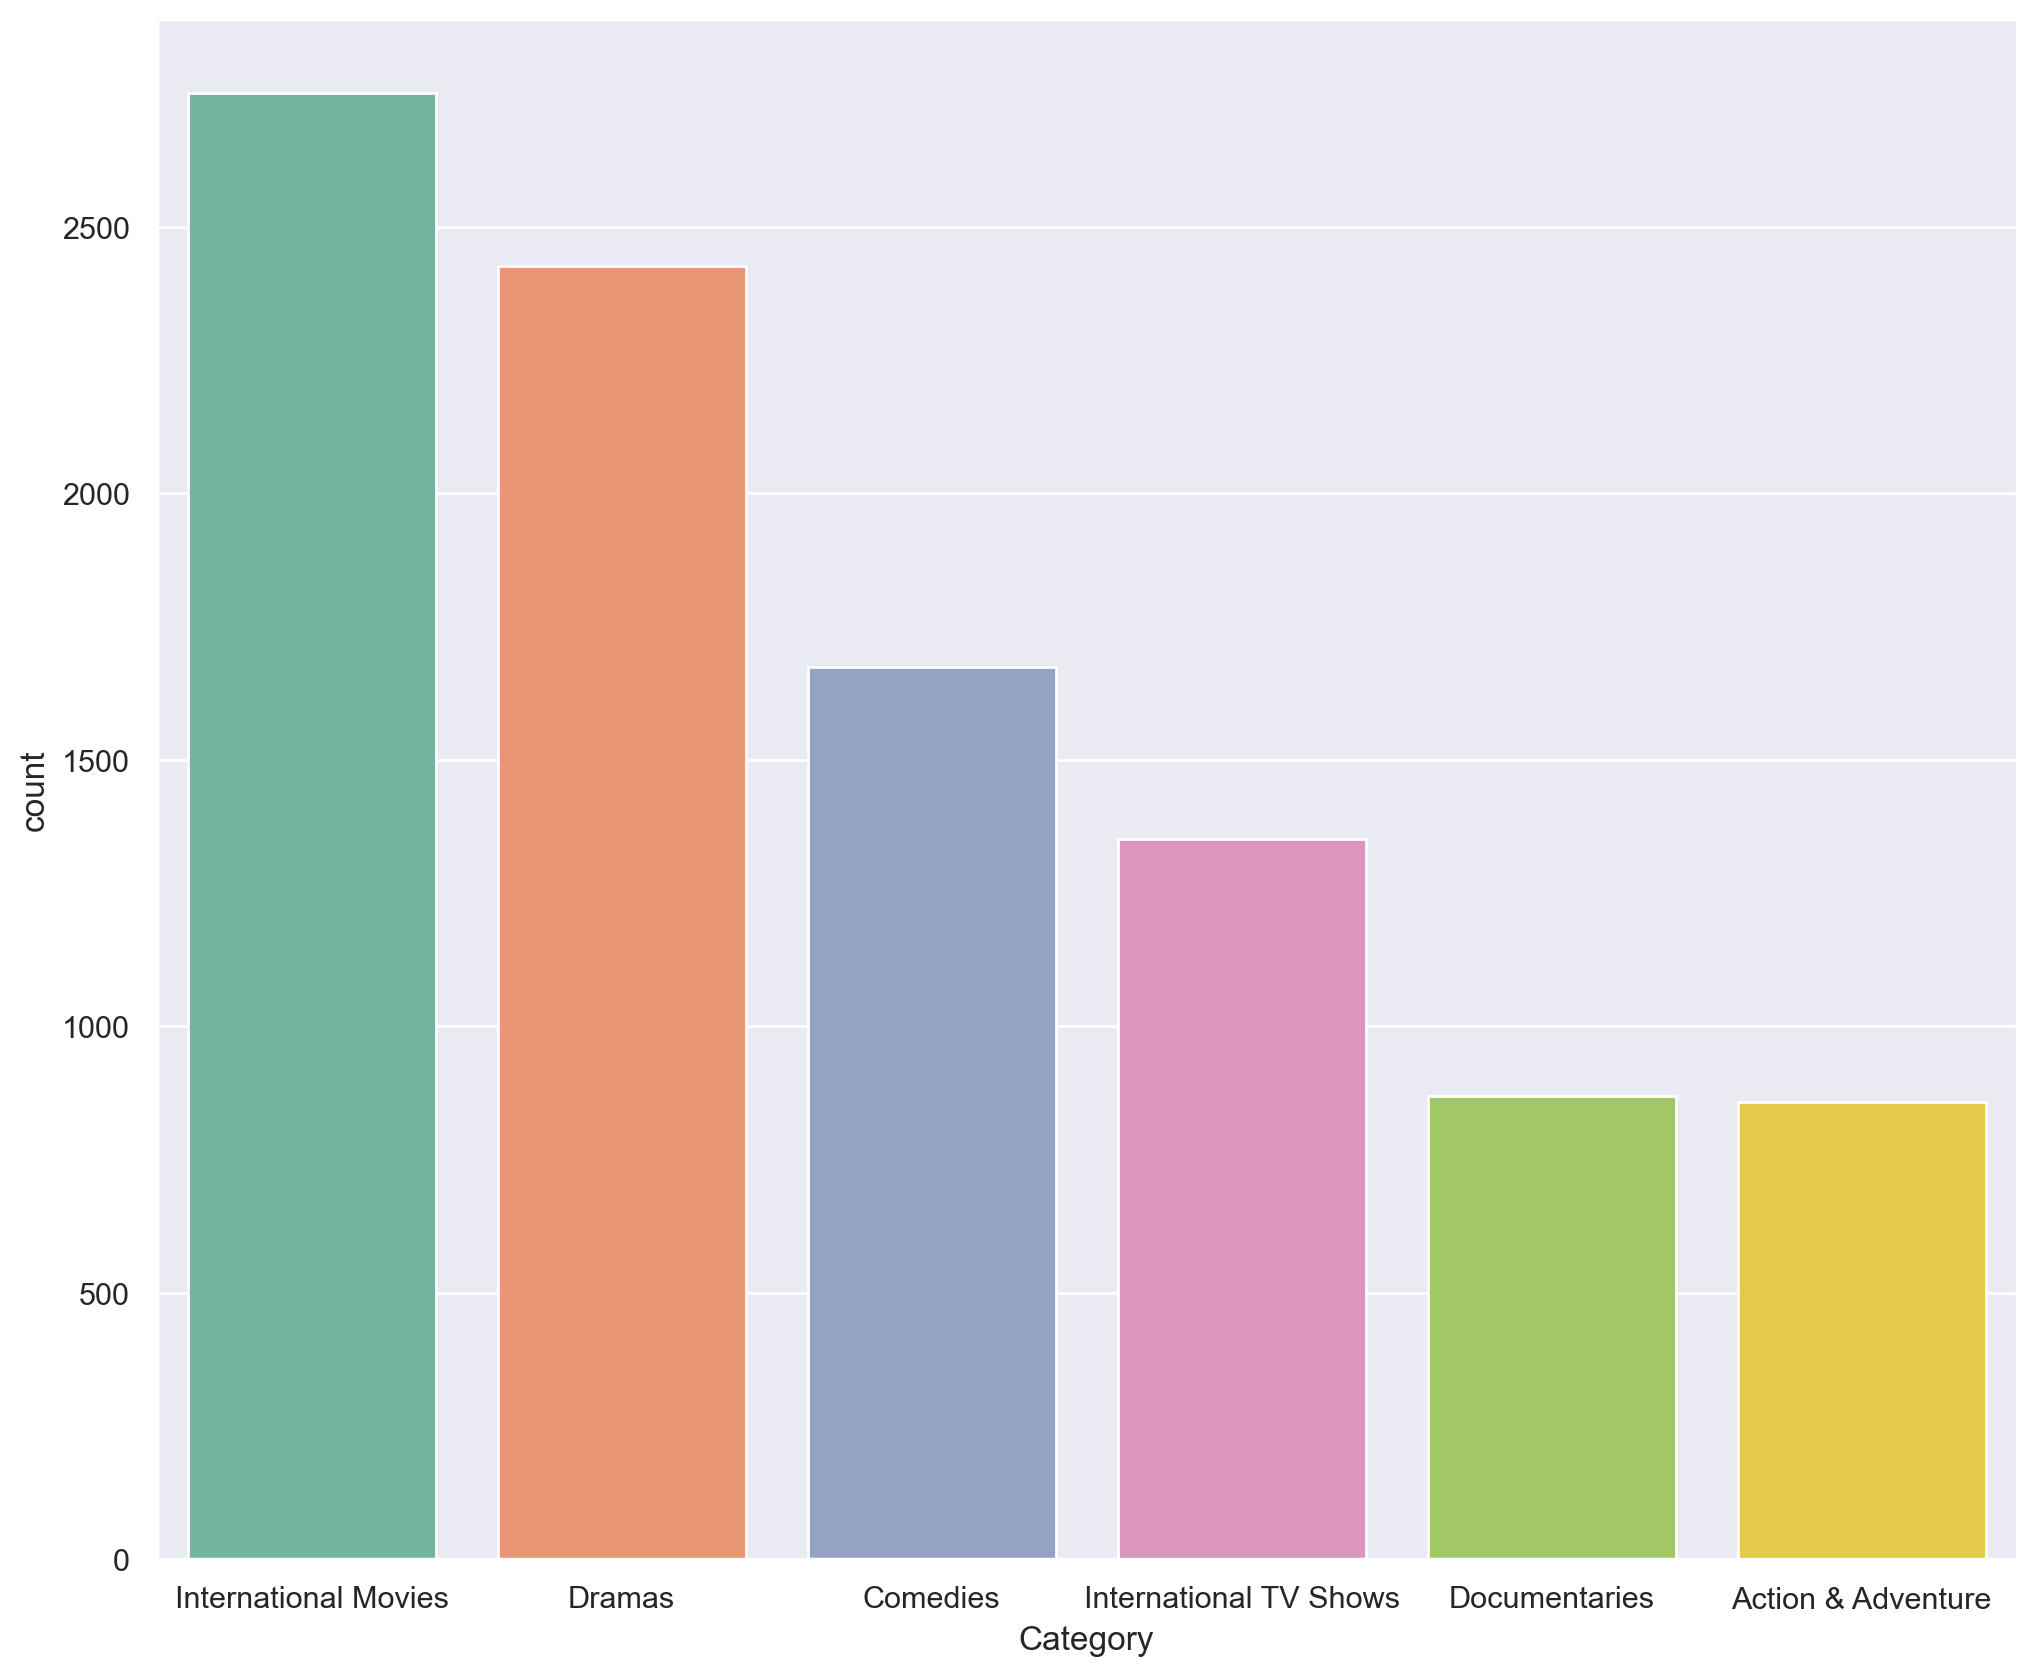

In [214]:
plt.rcParams['figure.dpi'] = 200

a = pd.DataFrame({"Category": [y for x in data["listed_in"] for y in x]})
plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="Category", data=a, palette="Set2", order=a["Category"].value_counts().index[0:6])

Dramas and comedies are the most frequent categories besides international movies/TV shows. Besides this also documentaries as well as action & adventure categories have a lot of content in them.

<Axes: xlabel='Cast_member', ylabel='count'>

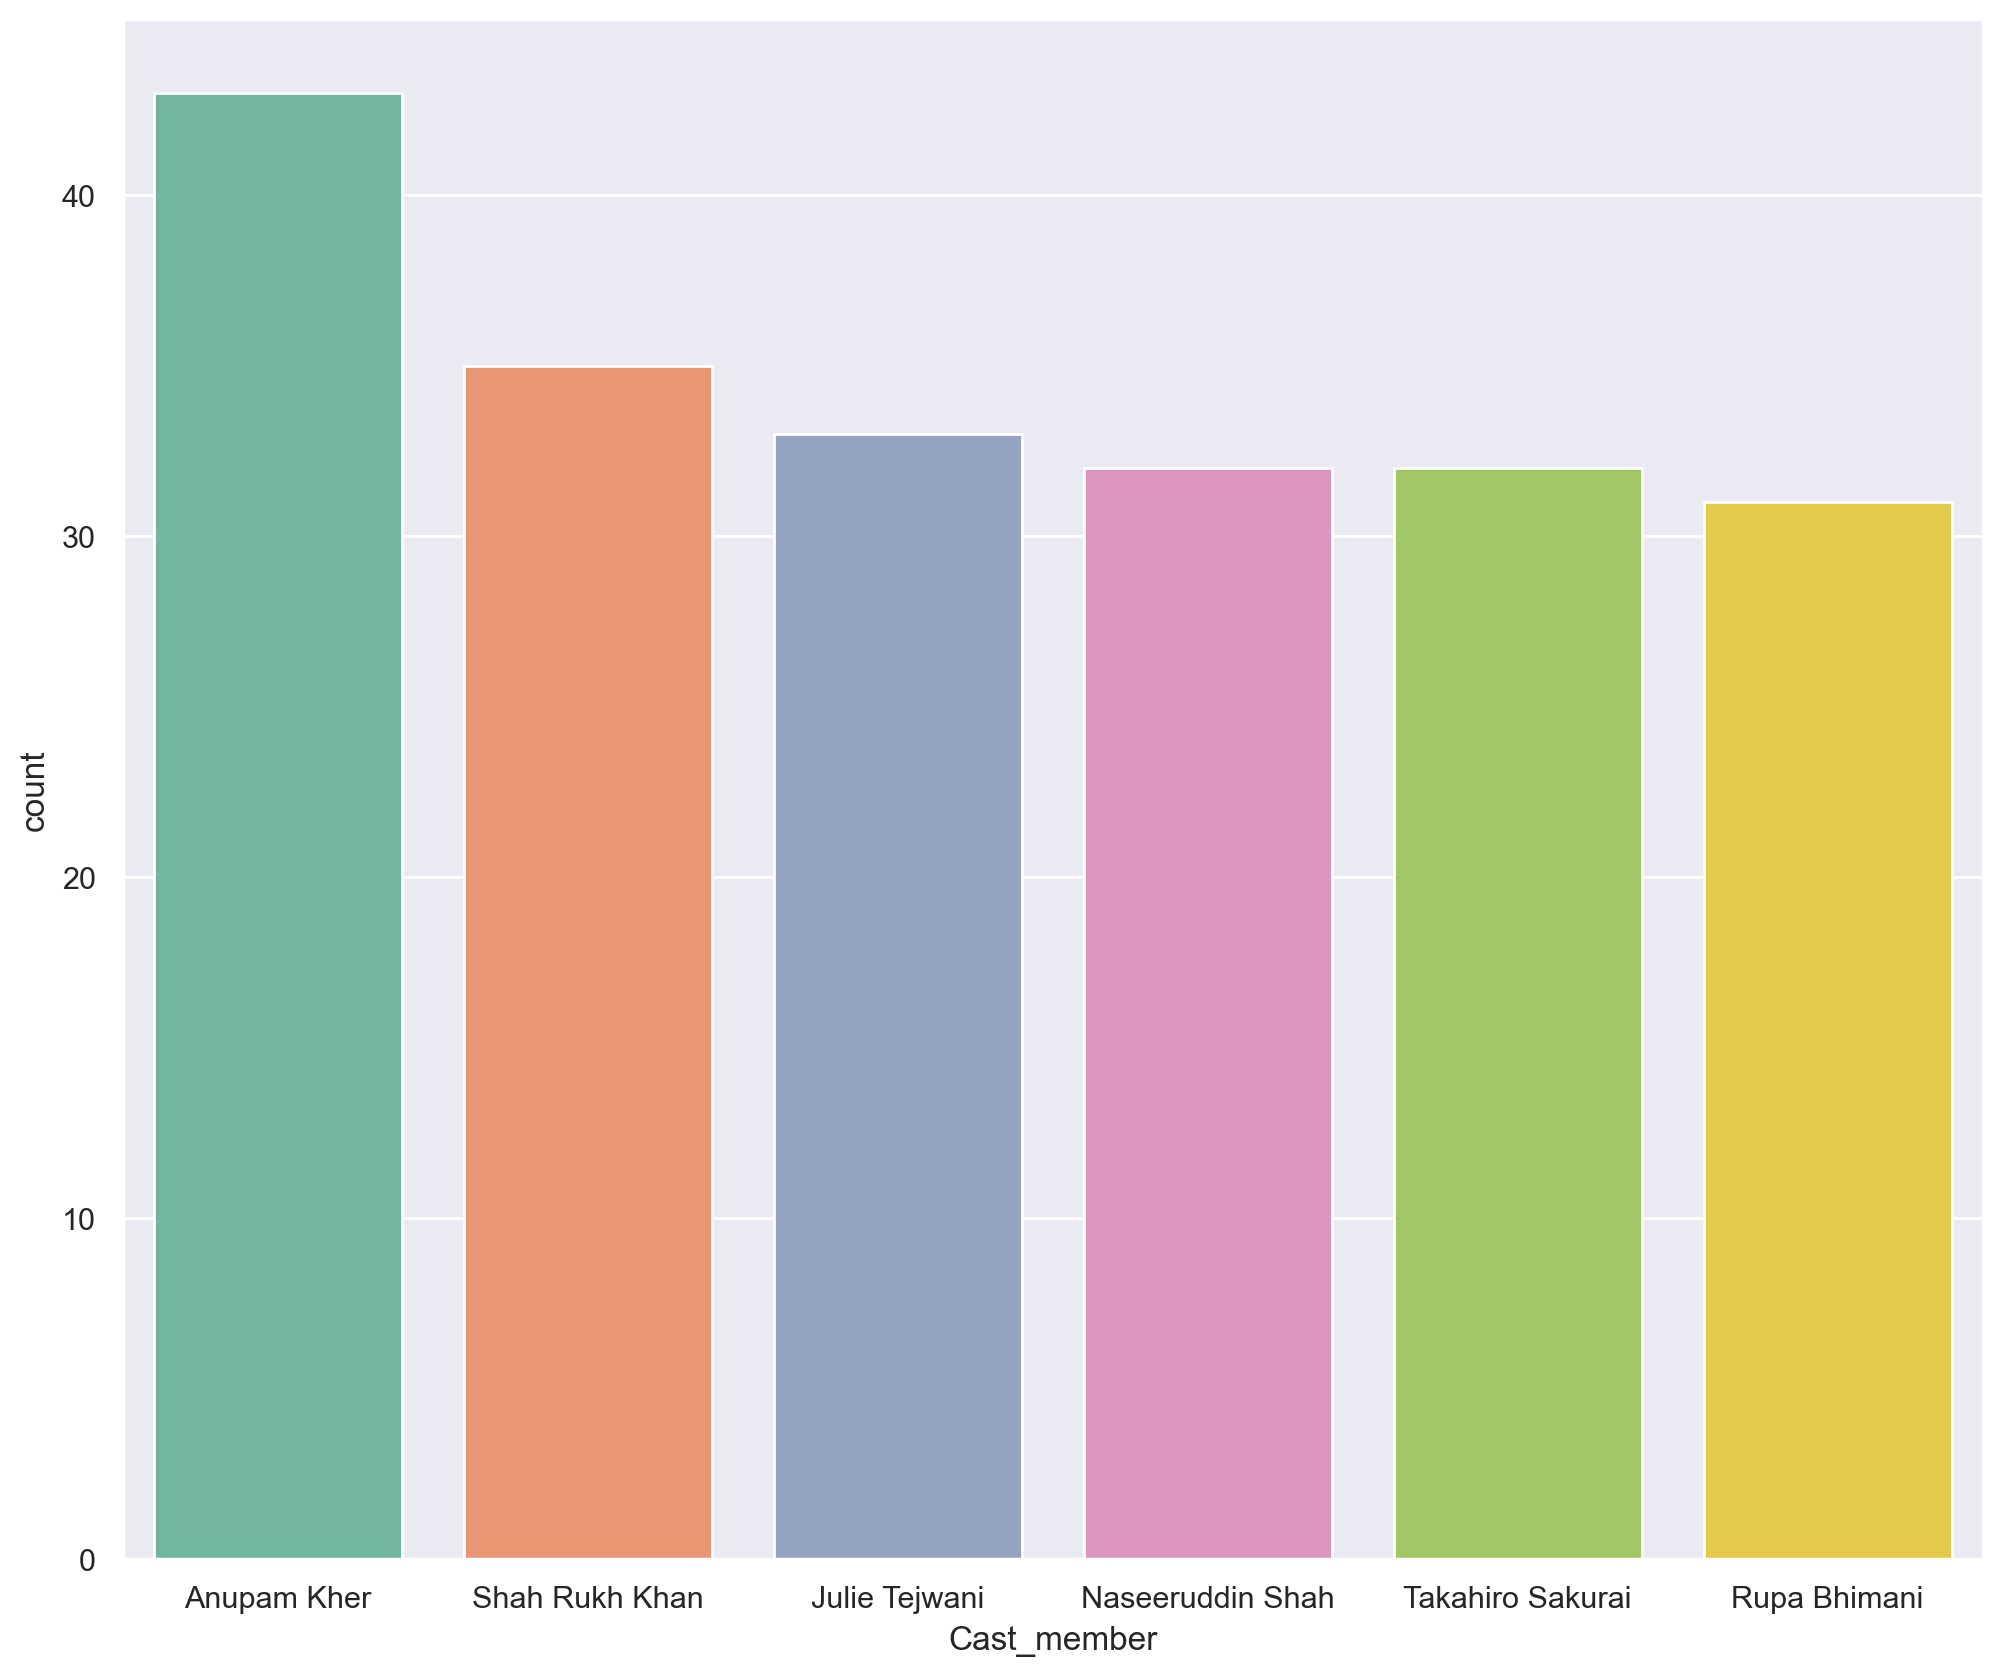

In [215]:
plt.rcParams['figure.dpi'] = 200

a = pd.DataFrame({"Cast_member": [y for x in data["cast"] for y in x if y!="Unknown"]})
plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="Cast_member", data=a, palette="Set2", order=a["Cast_member"].value_counts().index[0:6])

Anupam Khew, Shah Rukh Khan, Julie Tejwani, Naseeruddin Shah, Takahiro Sakurai and Rupa Bhimani have taken part in the most Netflix shows/movies.

## Bivariate analysis

Lets now take a look at the relationships between different variables starting with the amount of TV shows and movies produces by different countries.

<Axes: xlabel='country', ylabel='count'>

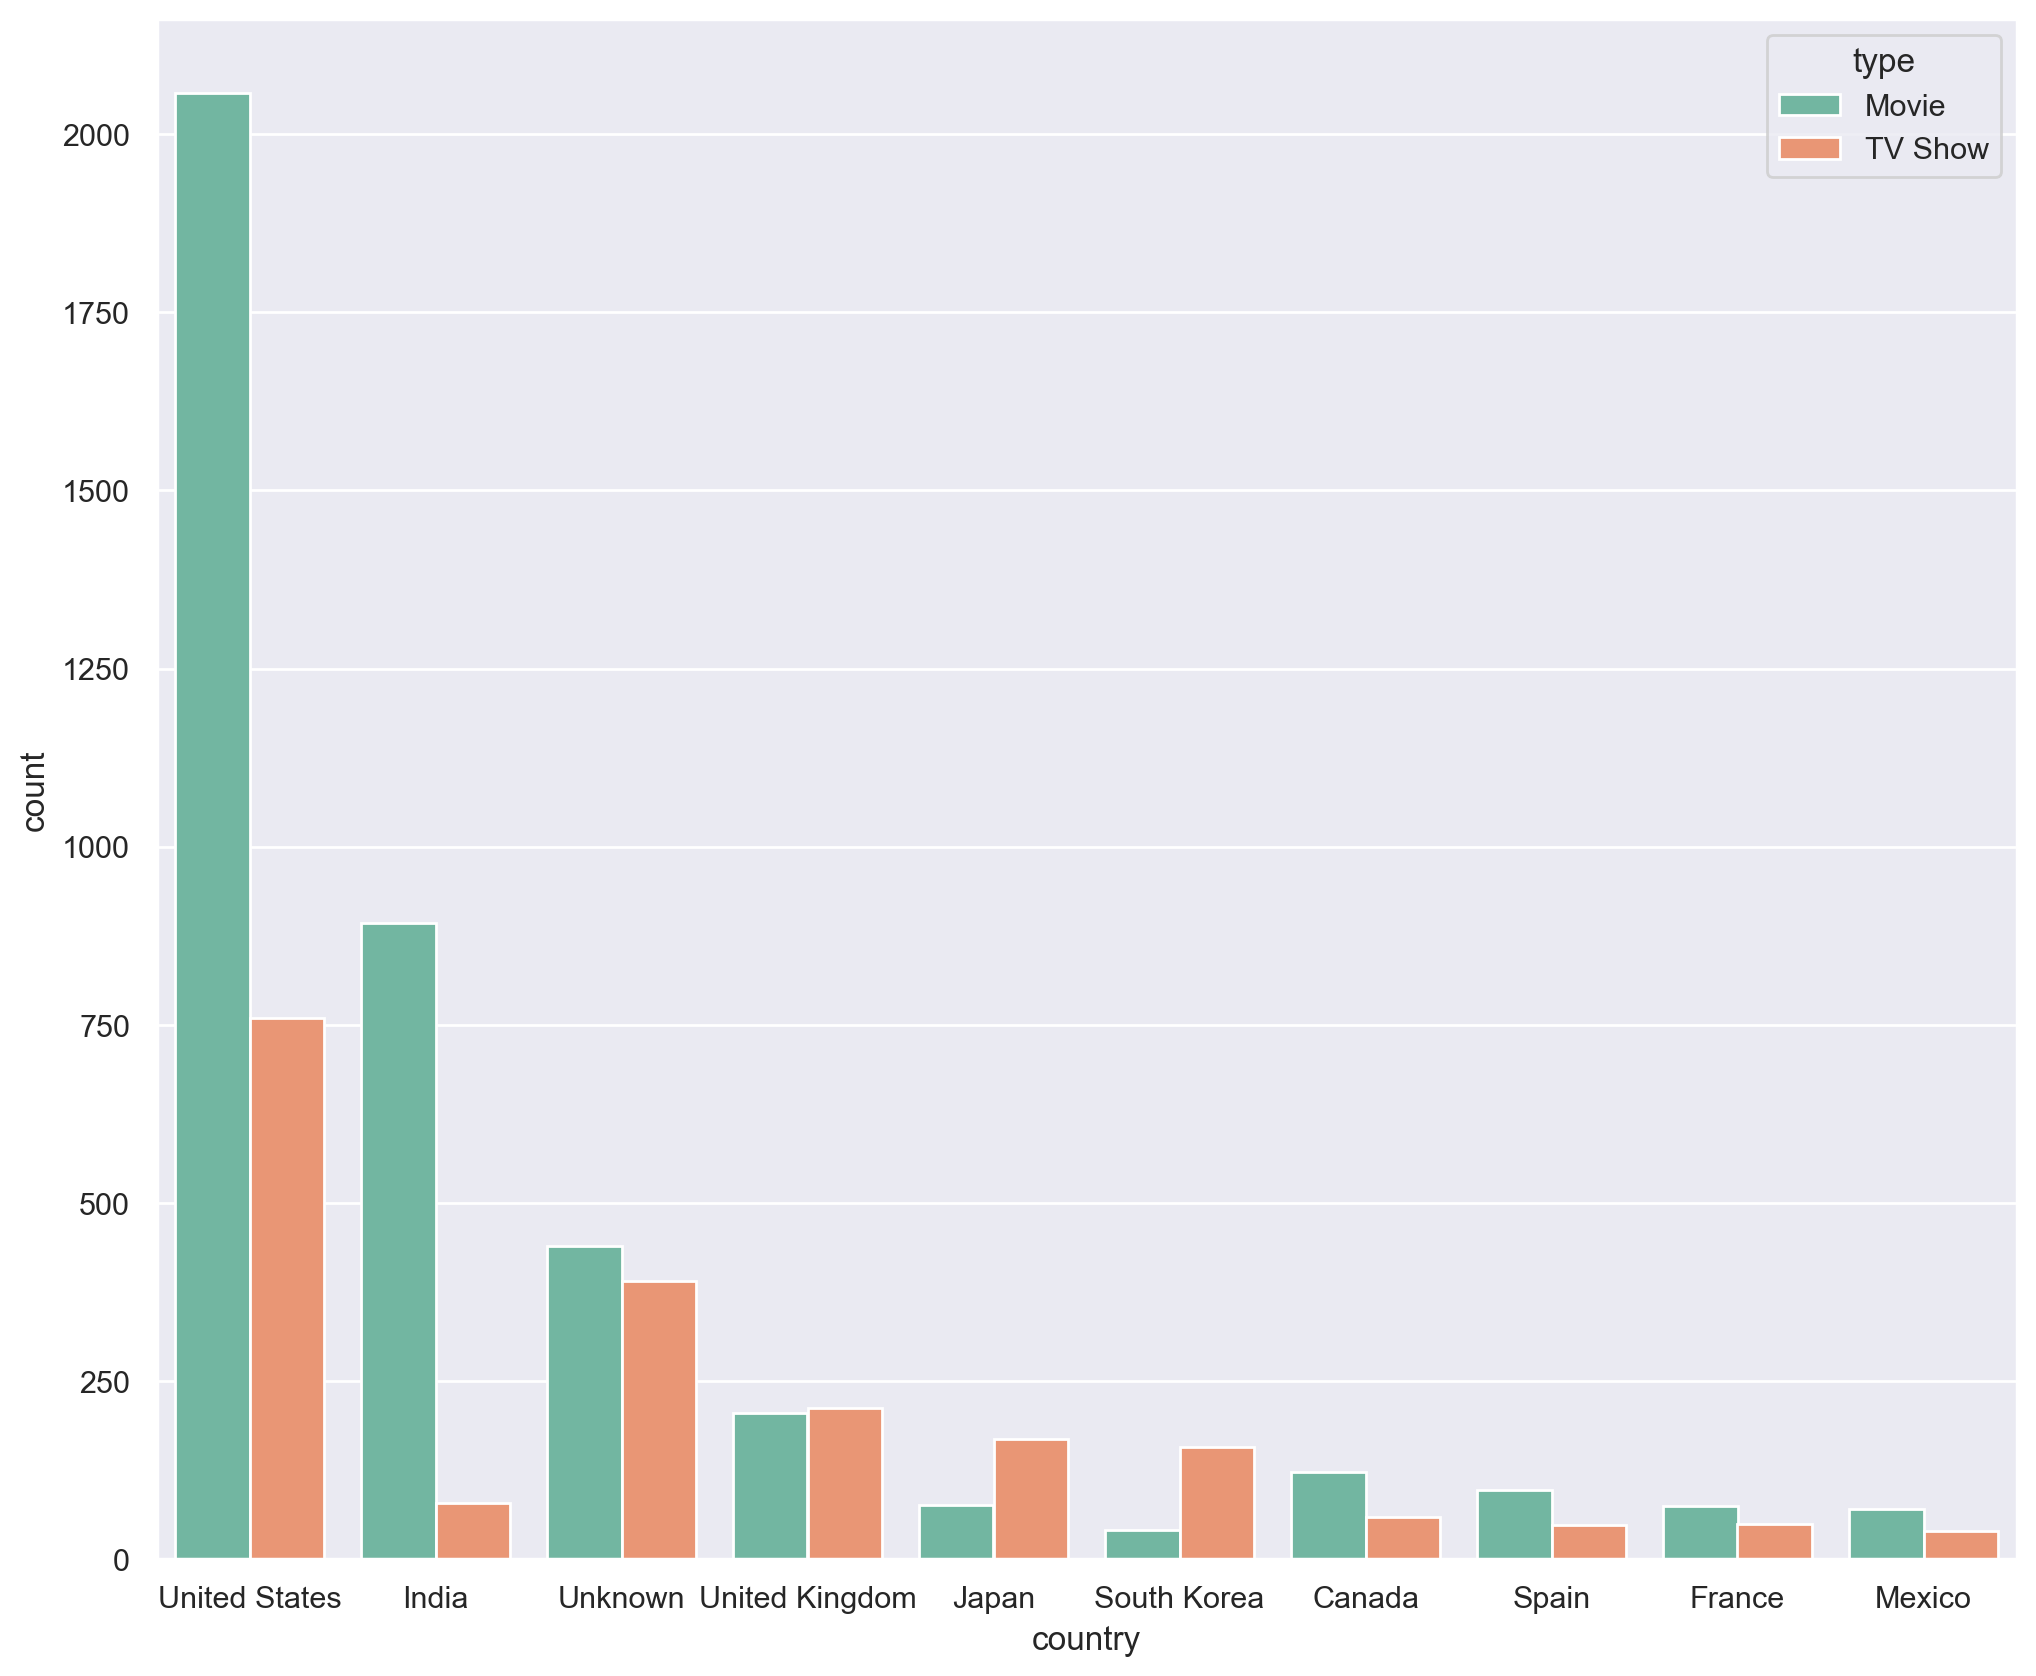

In [216]:
plt.rcParams['figure.dpi'] = 200

plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="country", hue="type", data=data, palette="Set2", order=data["country"].value_counts().index[0:10])

We can see that the proportions differ greatly based on the country of origin: the United States and India produce much more movies than TV shows but Japan and South Korea, on the other hand, do the exact opposite, and the United Kingdom has produced nearly the same amount of both.

<Axes: xlabel='rating', ylabel='count'>

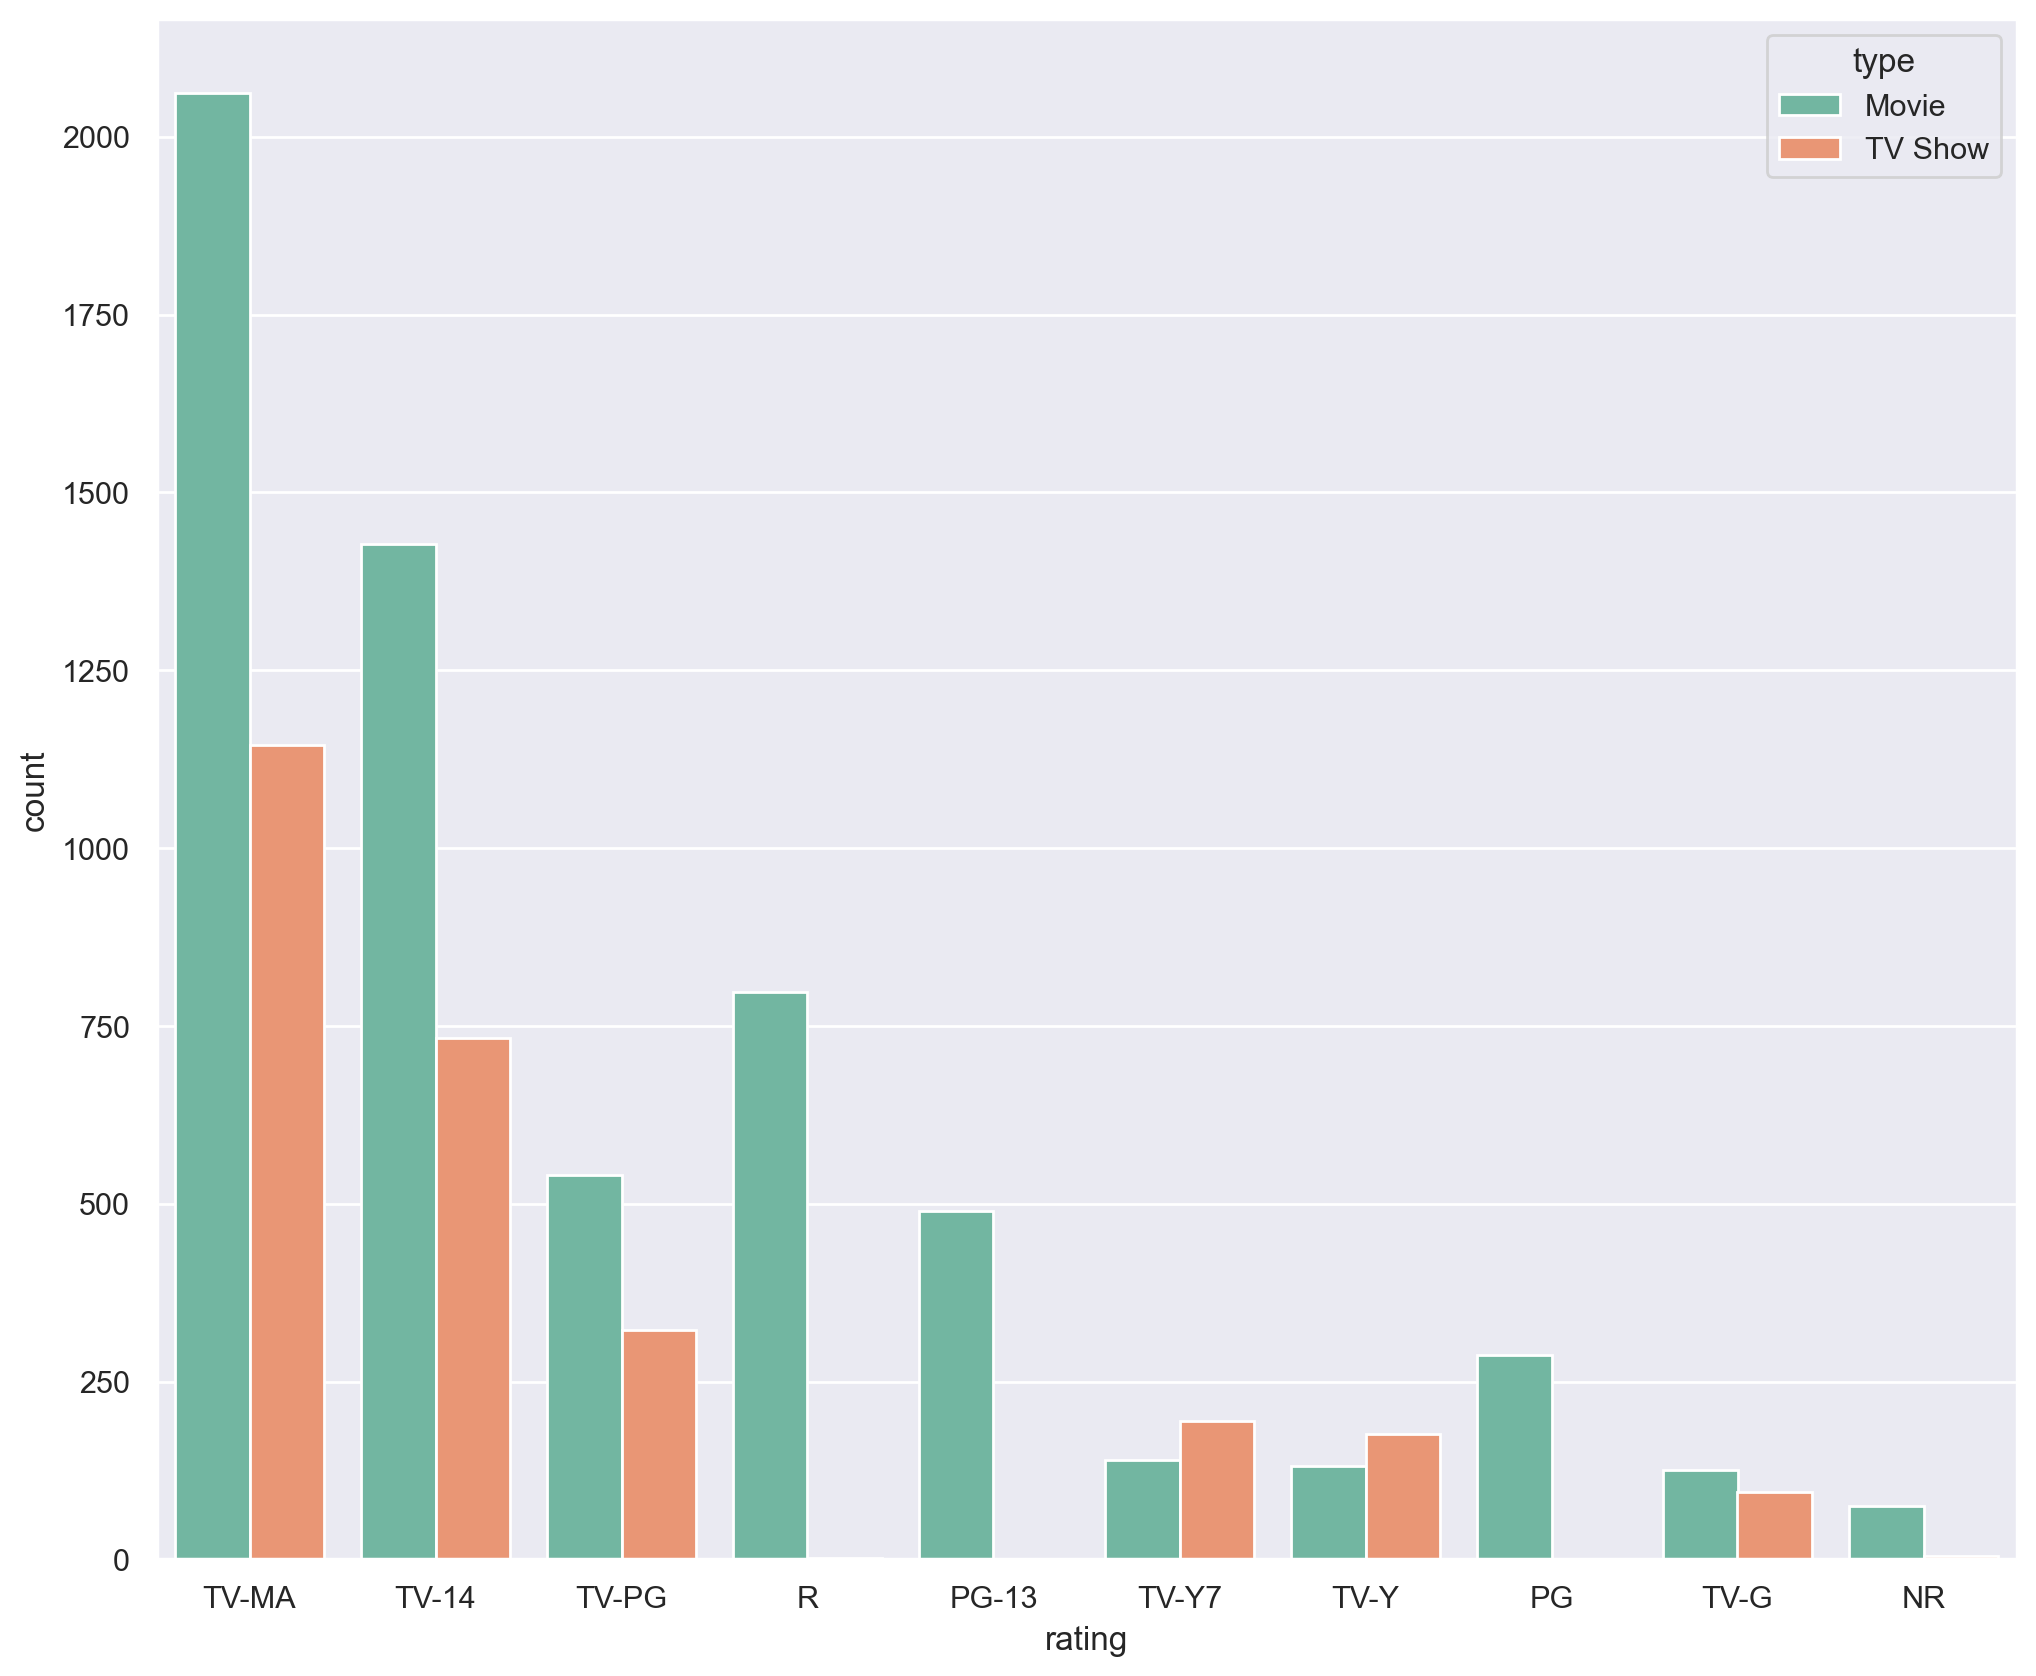

In [217]:
plt.rcParams['figure.dpi'] = 200

plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="rating", hue="type", data=data, palette="Set2", order=data["rating"].value_counts().index[0:10])

Ratings TV-Y7 and TV-Y have a much larger share of TV shows compared to the total on Netflix. These ratings are for children age 7 and up, and for all children respectively. From this we can see that the content aimed for different age groups have a tendency towards a certain type: TV shows for children and movies for everyone else while still having a good amount of the other type as well.

<Axes: xlabel='country', ylabel='count'>

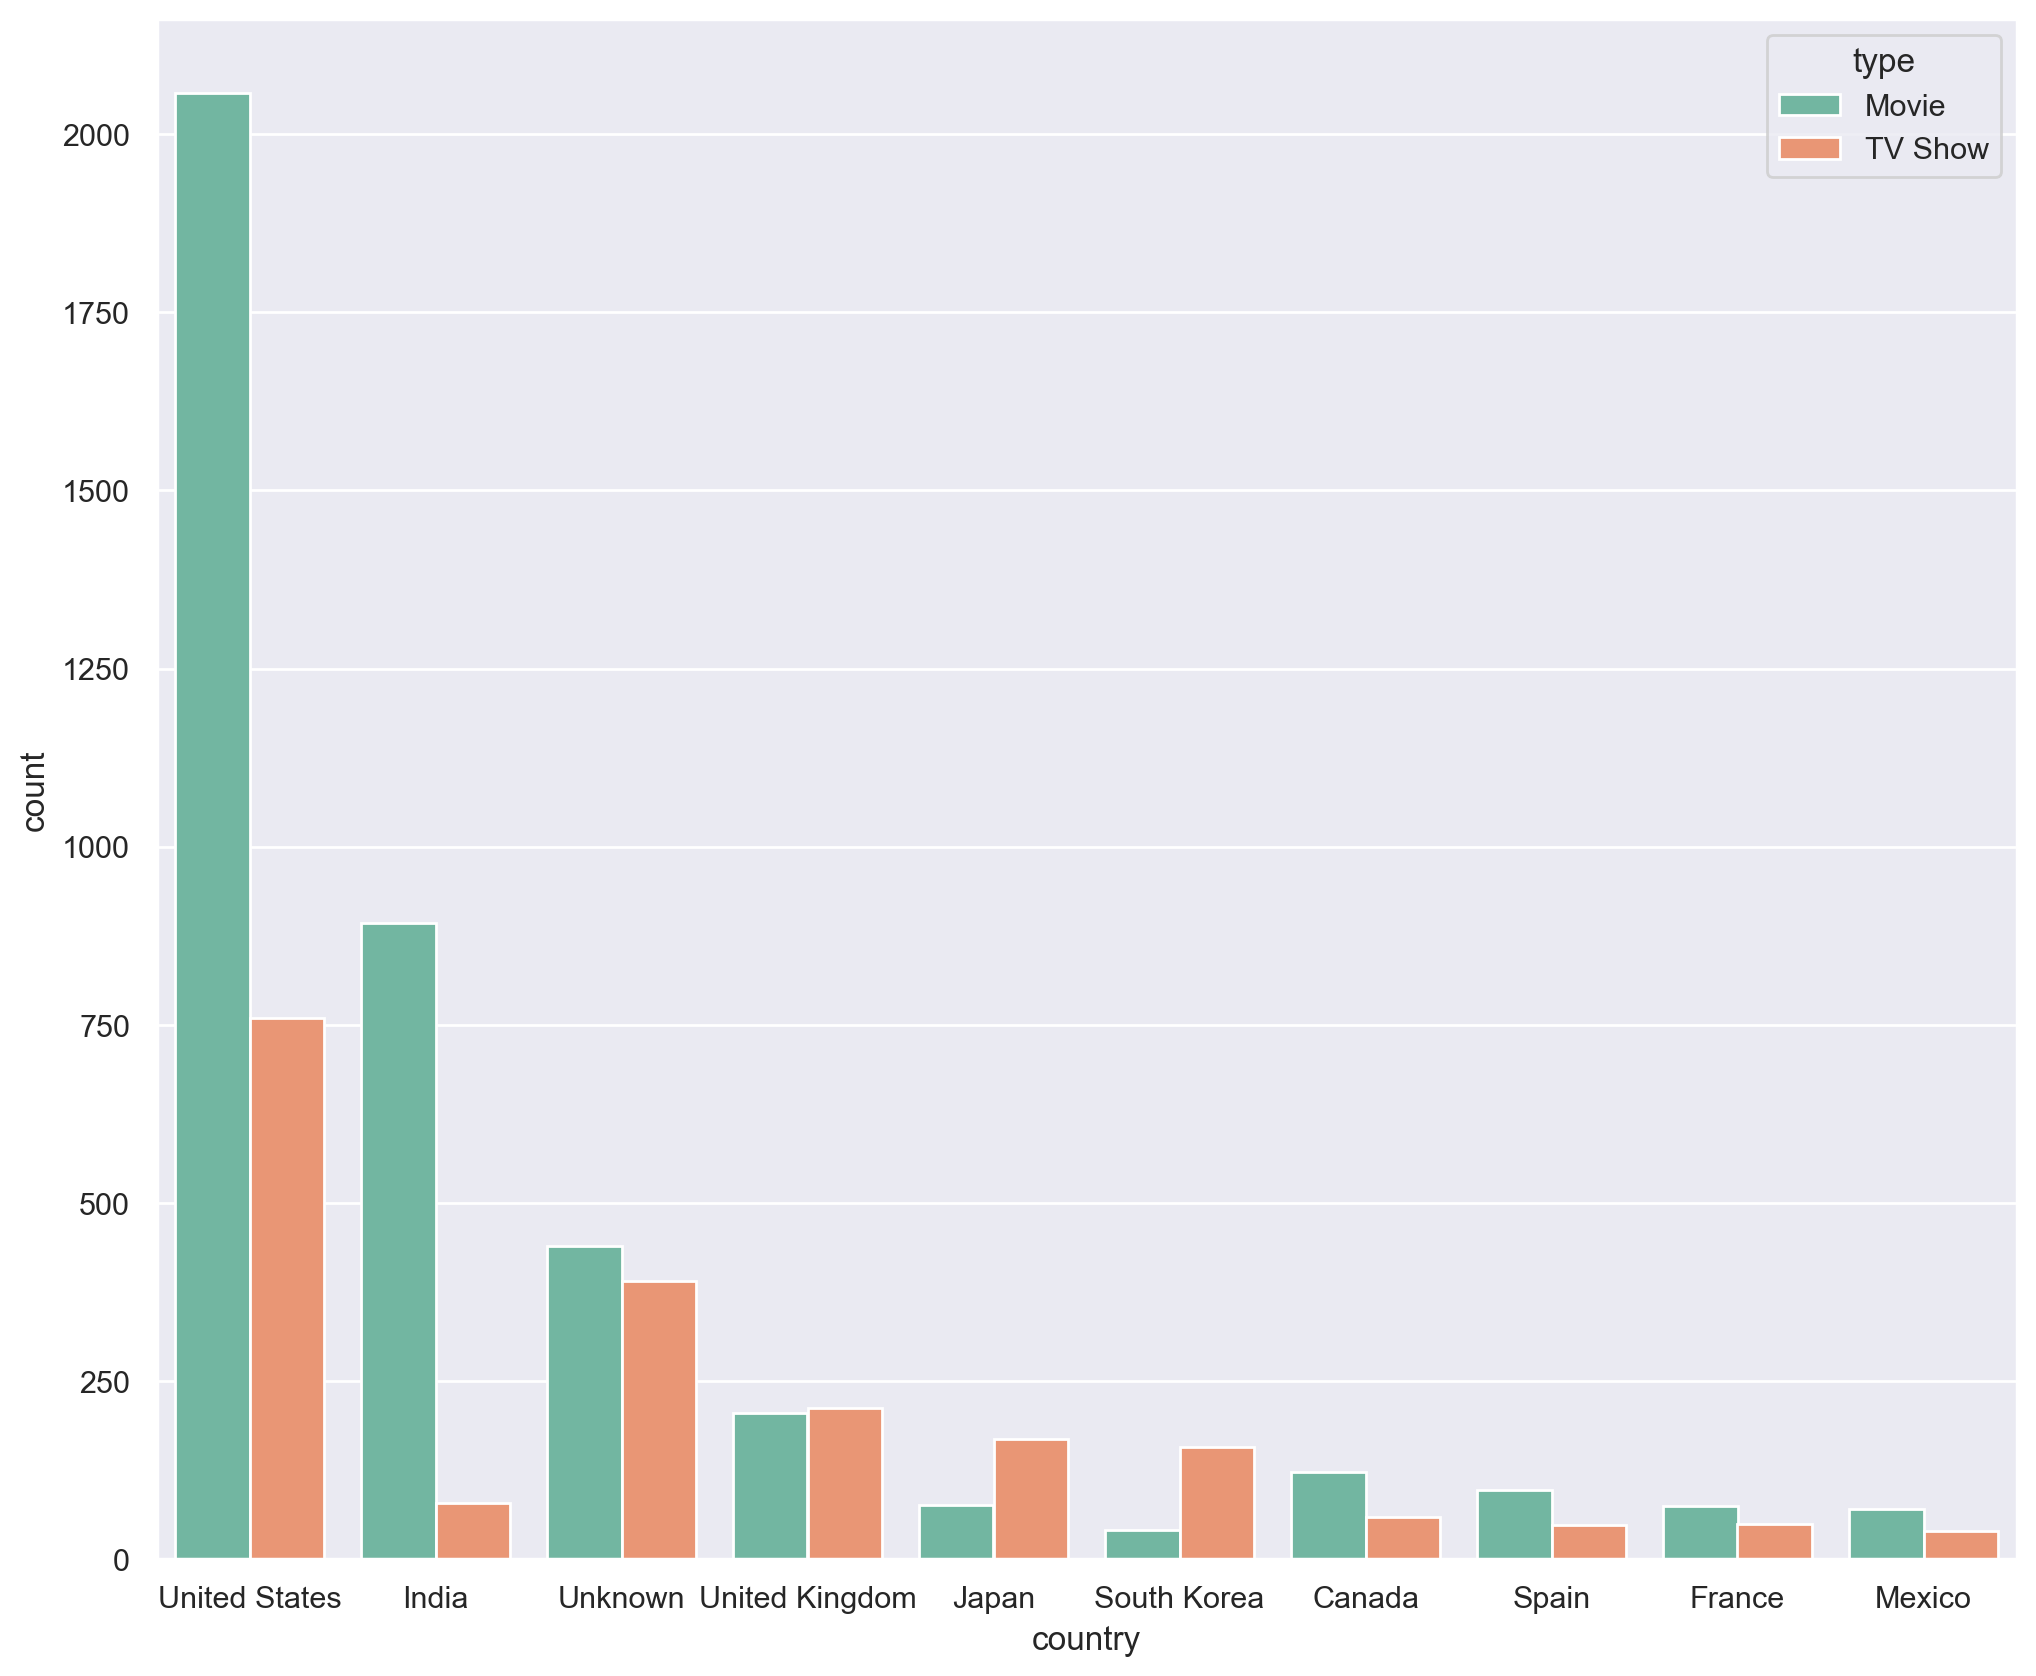

In [218]:
plt.rcParams['figure.dpi'] = 200

plt.figure(figsize=(12,10))
sb.set(style="darkgrid")
sb.countplot(x="country", hue="type", data=data, palette="Set2", order=data["country"].value_counts().index[0:10])

## Text analysis

We will take a look at the words used in the titles and descriptions to get a better idea of the popular themes there.

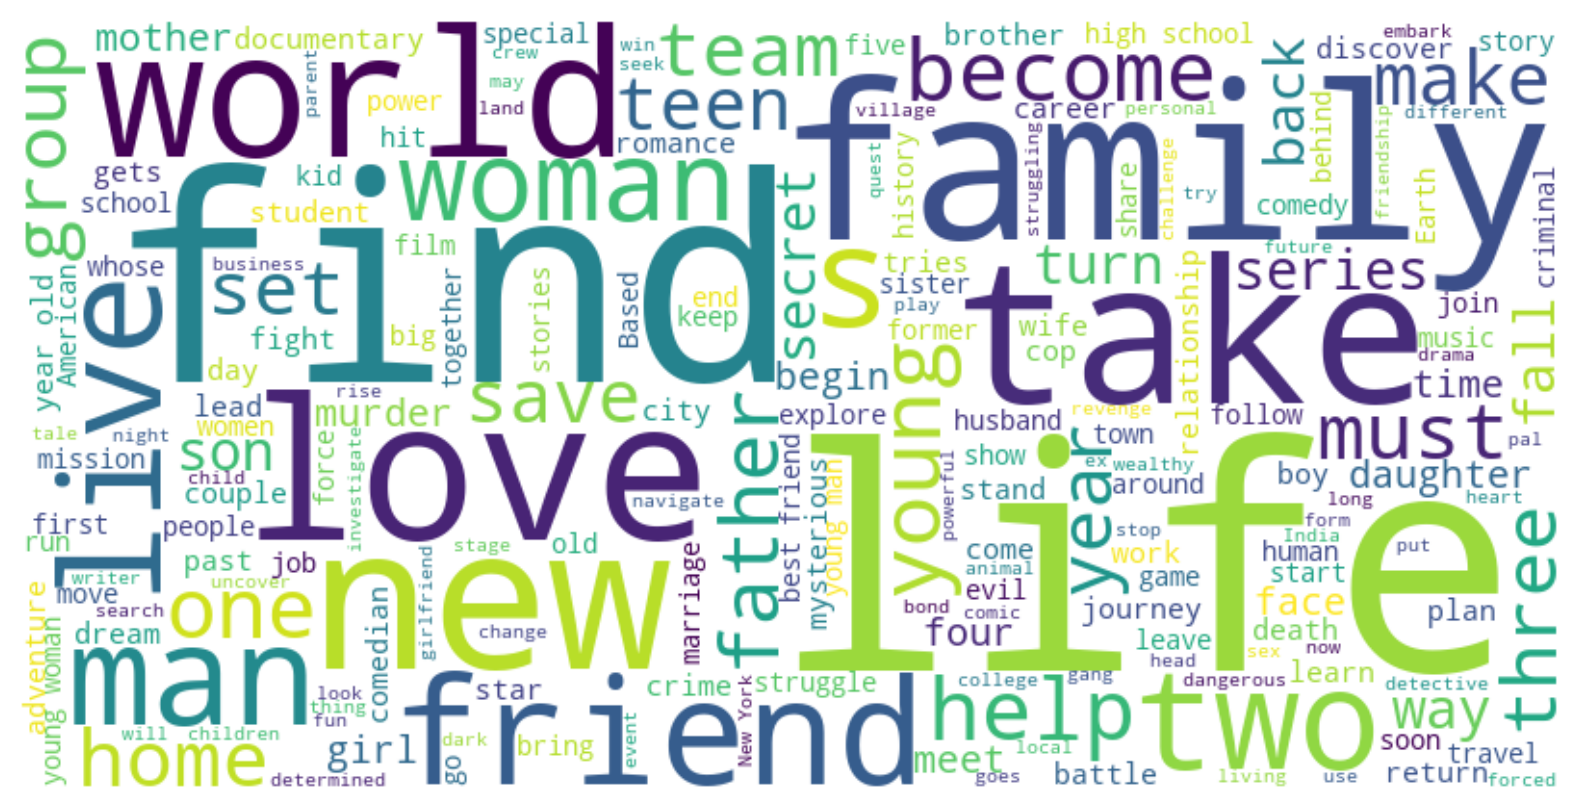

In [219]:
text = ' '.join(data[data["description"]!="Unknown"]['description'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

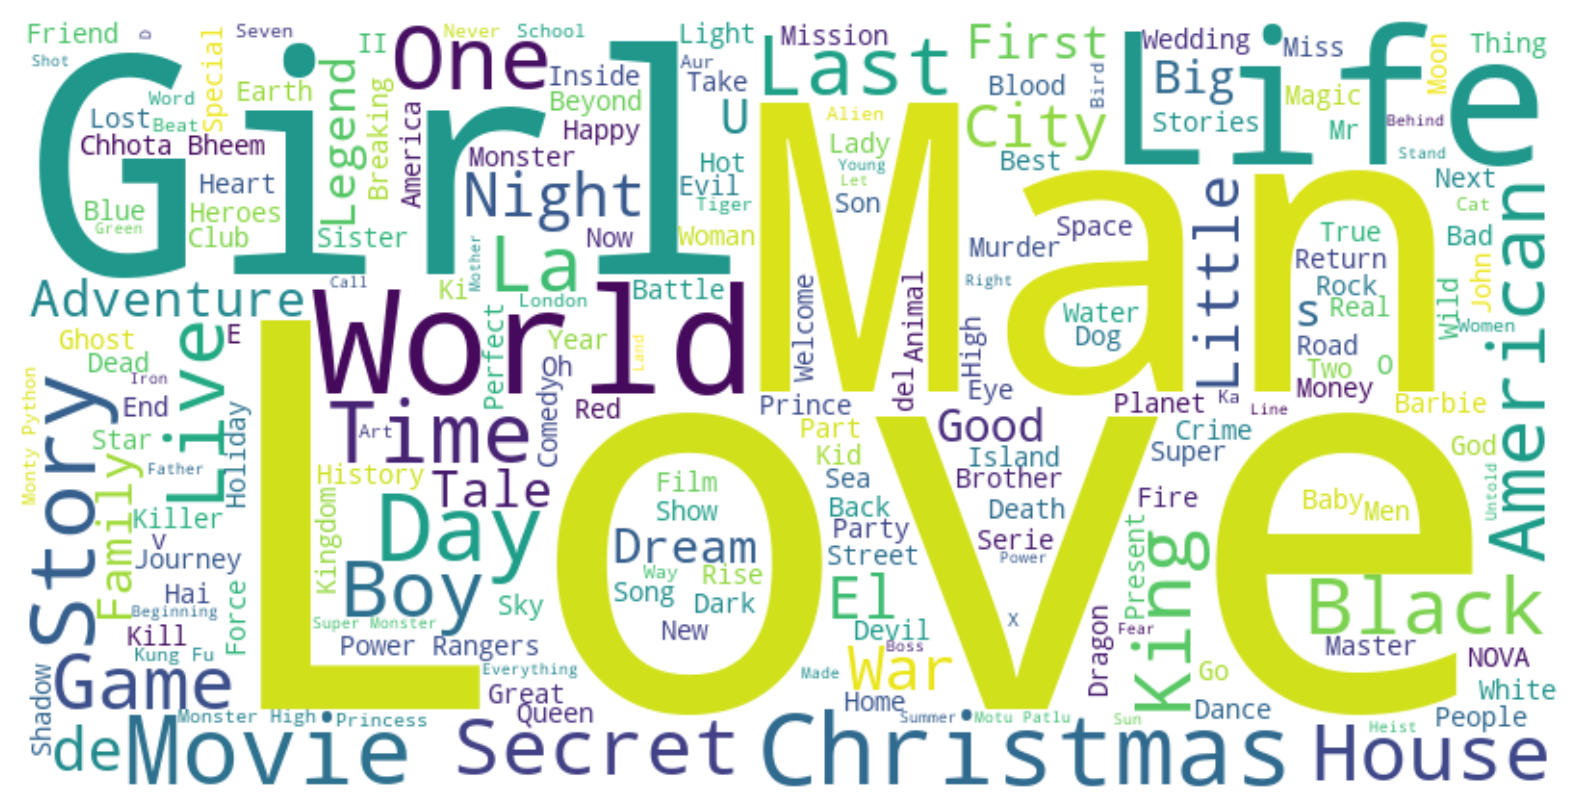

In [220]:
text = ' '.join(data['title'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

"Love" and "life" are extremely common in both titles and descriptions. Titles tend to use words "girl" and "man" much more often than the descriptions. Descriptions on the other hand tend to use words "find", "take", and "new" more frequently.

## Time series analysis

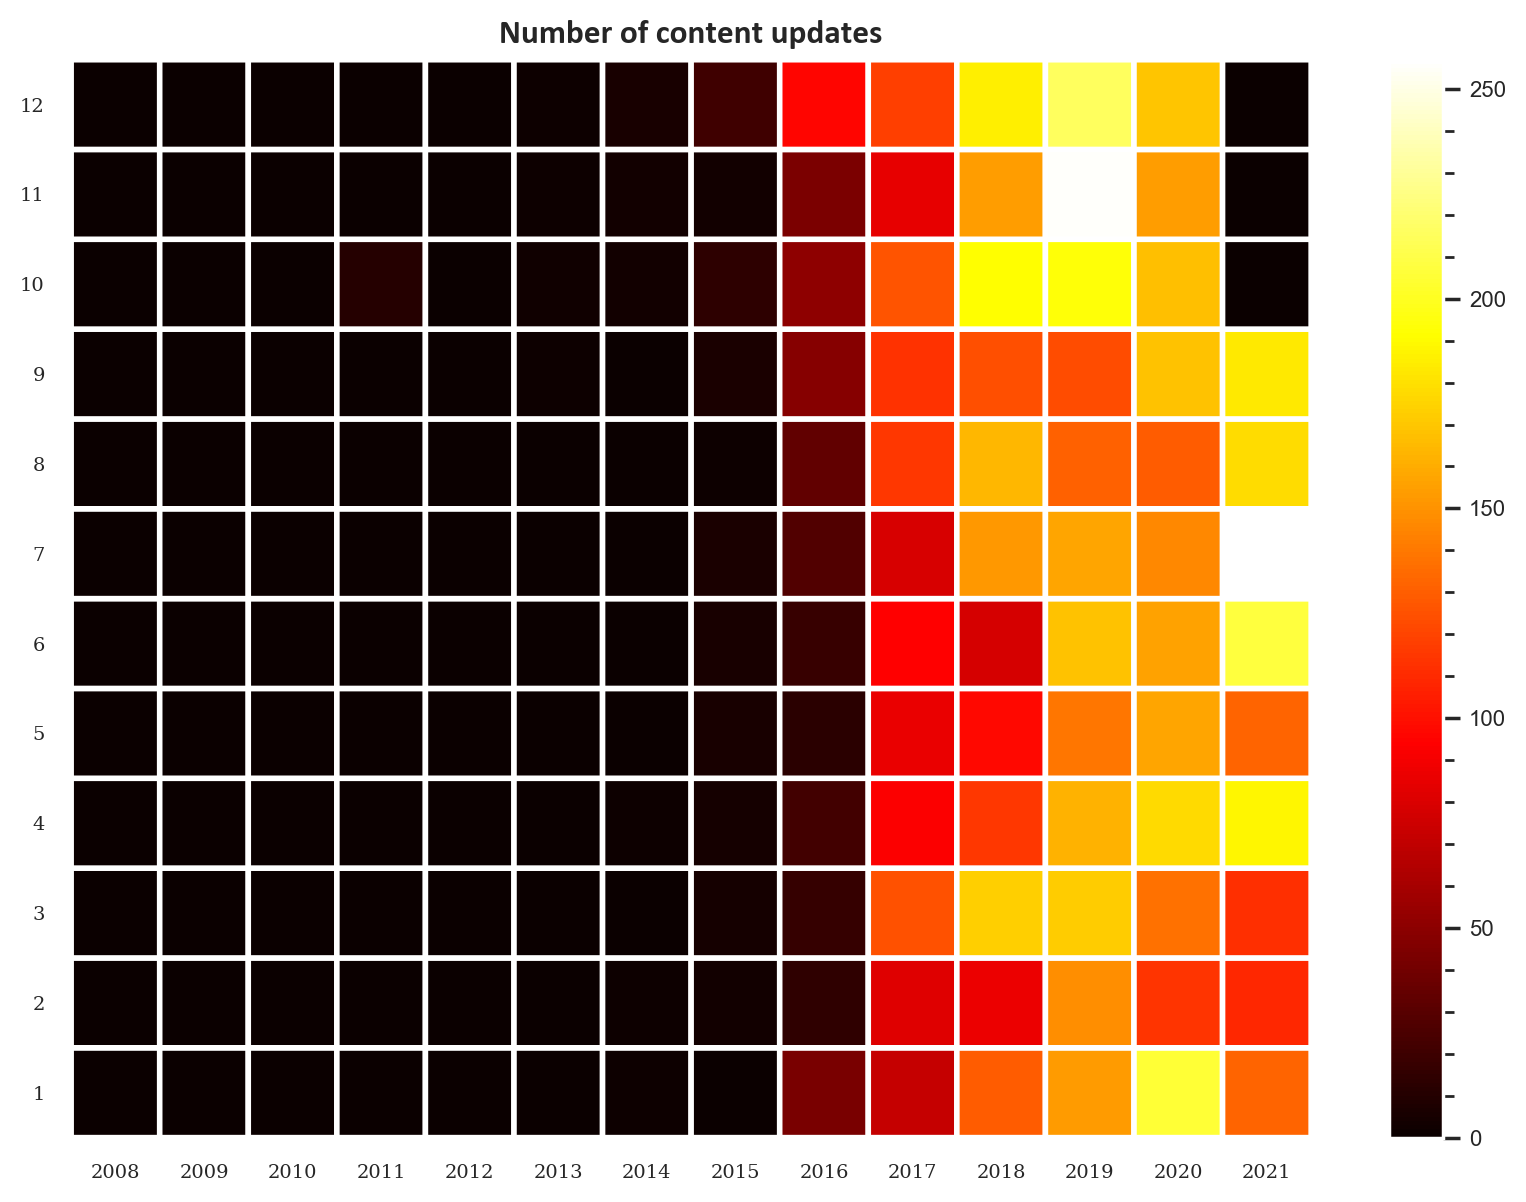

In [221]:
df = data.groupby('year_added')['month_added'].value_counts().unstack().fillna(0).drop(columns=[-1]).T.drop(columns=[-1])
plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(df, cmap='hot', edgecolors='white', linewidths=2) # heatmap
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')
plt.title('Number of content updates', fontsize=12, position=(0.50, 1.0+0.02))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 
cbar.ax.minorticks_on()
plt.show()

We can see here that February and May seem to have less content released compared to other months, so these could be good time periods to release more content.

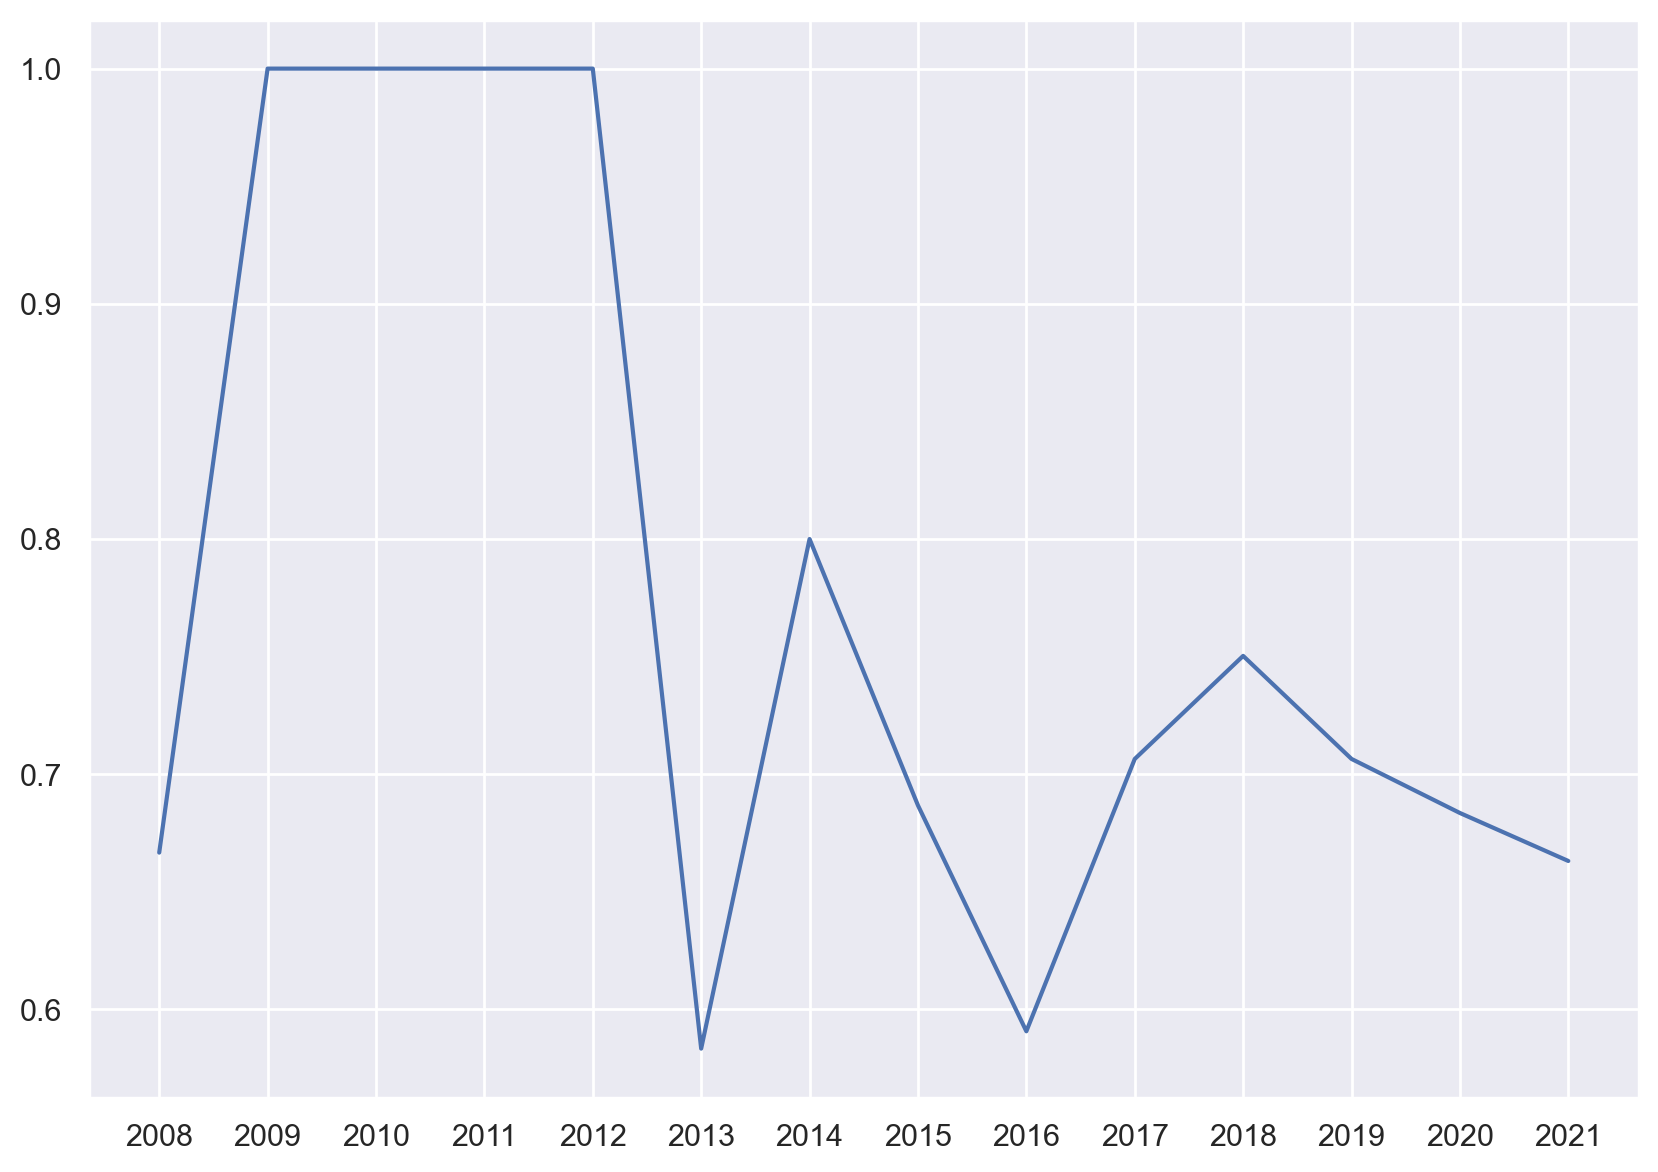

In [240]:
types = data.groupby('year_added')['type'].value_counts().unstack().fillna(0).T.drop(columns=[-1])
movie_amount = [(types[x][0]+1)/(types[x][1]+types[x][0]+1) for x in types.columns]
plt.figure(figsize=(10, 7), dpi=200)
plt.plot(types.columns, movie_amount)
plt.show()

The ratio between movies and TV shows has been relatively stable after the early days when very little content was added.

## Conclusion

Netflix has seen a monumental rise in popularity as well as the amount of content added starting around mid-2010s. The site has a wide variety of both movies and TV shows from all around the world with most of them coming from the United States, India and the United Kingdom. The target audience based on the age ratings of the content is clearly mostly the youth and adults. 

# Content recommendation system

We can use this data to create a relatively simple system for recommending content to watch based on a piece of content the user has enjoyed.

In [242]:
data = pd.read_csv('netflix_titles.csv').fillna("na")
def find(query):
    return data.loc[data["title"].str.contains(query)]

In [243]:
def durationSimilarity(row1, row2):
    if row1["duration"] == "na" or row2["duration"]=="na":
        return 1**-10
    sim = (row1["type"] == row2["type"]) + 1**-10
    if row1["type"]=="Movie" and row2["type"]=="Movie":
        sim = 1 / ((abs( int(row1["duration"].split(" ")[0]) - int(row2["duration"].split(" ")[0]) ))**2+1)
    return sim

def releaseYearSimilarity(row1, row2):
    sim = 1 / ((abs( int(row1["release_year"]) - int(row2["release_year"]) ))**2+1)
    return sim

def infoSimilarity(row1, row2):
    row1 = row1["type"]+", "+row1["director"]+", "+row1["cast"]+", "+row1["country"]+", "+row1["rating"]
    row2 = row2["type"]+", "+row2["director"]+", "+row2["cast"]+", "+row2["country"]+", "+row2["rating"]
    cat1 = [x.split(", ") for x in row1]
    cat2 = [x.split(", ") for x in row2]
    n1 = len(cat1)
    n2 = len(cat2)
    sim = 1**-10
    for cat in cat1:
        sim += (cat in cat2) * (1/max(n1,n2)) * (cat != "na")
    return sim

def listedinSimilarity(row1, row2):
    cat1 = [x.split(", ") for x in row1["listed_in"]]
    cat2 = [x.split(", ") for x in row2["listed_in"]]
    n1 = len(cat1)
    n2 = len(cat2)
    sim = 1**-10
    for cat in cat1:
        sim += (cat in cat2) * (1/max(n1,n2)) * (cat != "na")
    return sim

def totalSimilarity(row1, row2, metrics, weights):
    log_sim = 1**-10
    for i in range(len(metrics)):
        log_sim += np.log( weights[i] * metrics[i](row1, row2) )
    return log_sim

def findNMostSimilar(row, data, n):
    n2 = len(data)
    sim = [0]*n2
    for i in range(n2):
        if row["title"]==data.iloc[i]["title"]:
            sim[i] = 0
        else:
            sim[i] = totalSimilarity(row, data.iloc[i], [durationSimilarity, releaseYearSimilarity, infoSimilarity, listedinSimilarity], [1, 2, 3, 5])
    ind = np.argsort(sim)[::-1]
    res = [""]*n
    for i in range(n):
        res[i] = data.iloc[ind[i]]
    return res

We can test this system by looking recommendations for people who have watched the highly popular Squid game.

In [244]:
findNMostSimilar(data.iloc[33], data, 5)

[show_id                                                      s885
 type                                                      TV Show
 title                                              Move to Heaven
 director                                                       na
 cast            Lee Je-hoon, Tang Jun-sang, Hong Seung-hee, Ji...
 country                                               South Korea
 date_added                                           May 14, 2021
 release_year                                                 2021
 rating                                                      TV-MA
 duration                                                 1 Season
 listed_in                       International TV Shows, TV Dramas
 description     Finding life in all that’s left behind, a deta...
 Name: 884, dtype: object,
 show_id                                                     s1286
 type                                                      TV Show
 title                             

The recommendations seem to make sense as most of these are also from South Korea but to judge the results accurately they would need to be tested on actual users. This system could also be tuned and improved with AB testing.